[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train RF-DETR Object Detection on a Custom Dataset

---

[![hf space](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/SkalskiP/RF-DETR)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-finetune-rf-detr-on-detection-dataset.ipynb)
[![roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/rf-detr)
[![code](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/rf-detr)

RF-DETR is a real-time, transformer-based object detection model architecture developed by Roboflow and released under the Apache 2.0 license.

![rf-detr-coco-rf100-vl-8](https://media.roboflow.com/rfdetr/pareto.png)

The RF-DETR family of models stands as the quickest and most precise in object detection across all sizes. RF-DETR has achieved over 60 mAP on the Microsoft COCO benchmark, a leading measure of object detection performance. It also sets new records on RF100-VL, a benchmark that shows how well models adapt to real-world problems beyond standard datasets.

The RF-DETR model group includes five sizes: Nano, Small, Medium, Base, and Large. These models offer a range of options for different needs. For example, RF-DETR-Nano is 11 mAP higher than YOLO11-n (on mAP50:95) and runs 0.17 ms faster. Likewise, RF-DETR-Small is 1.8 mAP better than YOLO11-x (the biggest YOLO11 model) and speeds things up by a good 7.77 ms. This wide range of models makes RF-DETR a great choice for many real-world uses, from small devices that need to be super fast to bigger jobs that demand top precision.

RF-DETR is small enough to run on edge devices, making it perfect for deployments that need both high accuracy and real-time performance. You can easily get started with any of the RF-DETR models, as they're ready for training in the cloud with Roboflow or through the free RF-DETR Python package.

## Environment setup

### Configure API Key

To fine-tune RF-DETR, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy` to copy your private API key.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store your Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Wed Aug  6 13:14:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   36C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

Installs RF-DETR version 1.2.1 or higher (which includes the new Nano, Small, and Medium checkpoints), along with Supervision for benchmarking and Roboflow for pulling datasets and uploading models to the Roboflow platform.

In [2]:
!pip install -q rfdetr==1.2.1 supervision==0.26.1 roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.8/372.8 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Downloads example images for testing. You can use these or replace them with your own images.

In [ ]:
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg

## Inference with Pre-trained COCO Model

Runs inference on an example image using a pretrained RF-DETR Medium model (trained on COCO). To use a different model size, simply replace `RFDETRMedium` with `RFDETRNano`, `RFDETRSmall`, `RFDETRBase` or `RFDETRLarge` as needed.

In [ ]:
import numpy as np
import supervision as sv

from PIL import Image

from rfdetr import RFDETRMedium
from rfdetr.util.coco_classes import COCO_CLASSES

image = Image.open("dog-2.jpeg")

model = RFDETRMedium(resolution=640)
model.optimize_for_inference()

detections = model.predict(image, threshold=0.5)

color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    smart_position=True
)

labels = [
    f"{COCO_CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = bbox_annotator.annotate(annotated_image, detections)
annotated_image = label_annotator.annotate(annotated_image, detections, labels)
annotated_image.thumbnail((800, 800))
annotated_image

## Download Dataset from Roboflow Universe

RF-DETR expects the dataset to be in COCO format. Divide your dataset into three subdirectories: `train`, `valid`, and `test`. Each subdirectory should contain its own `_annotations.coco.json` file that holds the annotations for that particular split, along with the corresponding image files. Below is an example of the directory structure:

```
dataset/
├── train/
│   ├── _annotations.coco.json
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ... (other image files)
├── valid/
│   ├── _annotations.coco.json
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ... (other image files)
└── test/
    ├── _annotations.coco.json
    ├── image1.jpg
    ├── image2.jpg
    └── ... (other image files)
```

[Roboflow](https://roboflow.com/annotate) allows you to create object detection datasets from scratch or convert existing datasets from formats like YOLO, and then export them in COCO JSON format for training. You can also explore [Roboflow Universe](https://universe.roboflow.com/) to find pre-labeled datasets for a range of use cases.

In [3]:
from roboflow import download_dataset

dataset = download_dataset("https://app.roboflow.com/mush-fu65b/ojdai-vqwce/1", "coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ojdai--1 in coco:: 100%|██████████| 7367/7367 [00:03<00:00, 1853.78it/s]


## Train RF-DETR on custom dataset

### Choose the right `batch_size`

Different GPUs have different amounts of VRAM (video memory), which limits how much data they can handle at once during training. To make training work well on any machine, you can adjust two settings: `batch_size` and `grad_accum_steps`. These control how many samples are processed at a time. The key is to keep their product equal to 16 — that’s our recommended total batch size. For example, on powerful GPUs like the A100, set `batch_size=16` and `grad_accum_steps=1`. On smaller GPUs like the T4, use `batch_size=4` and `grad_accum_steps=4`. We use a method called gradient accumulation, which lets the model simulate training with a larger batch size by gradually collecting updates before adjusting the weights.

In [ ]:
from rfdetr import RFDETRMedium

model = RFDETRMedium()

model.train(dataset_dir=dataset.location, epochs=10, batch_size=8, grad_accum_steps=2)

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


reinitializing your detection head with 6 classes.


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=6, grad_accum_steps=2, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=8, weight_decay=0.0001, epochs=10, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-medium.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=4, dim_feedforward=2048, hidden_dim=256, sa_nheads=8, ca_nheads

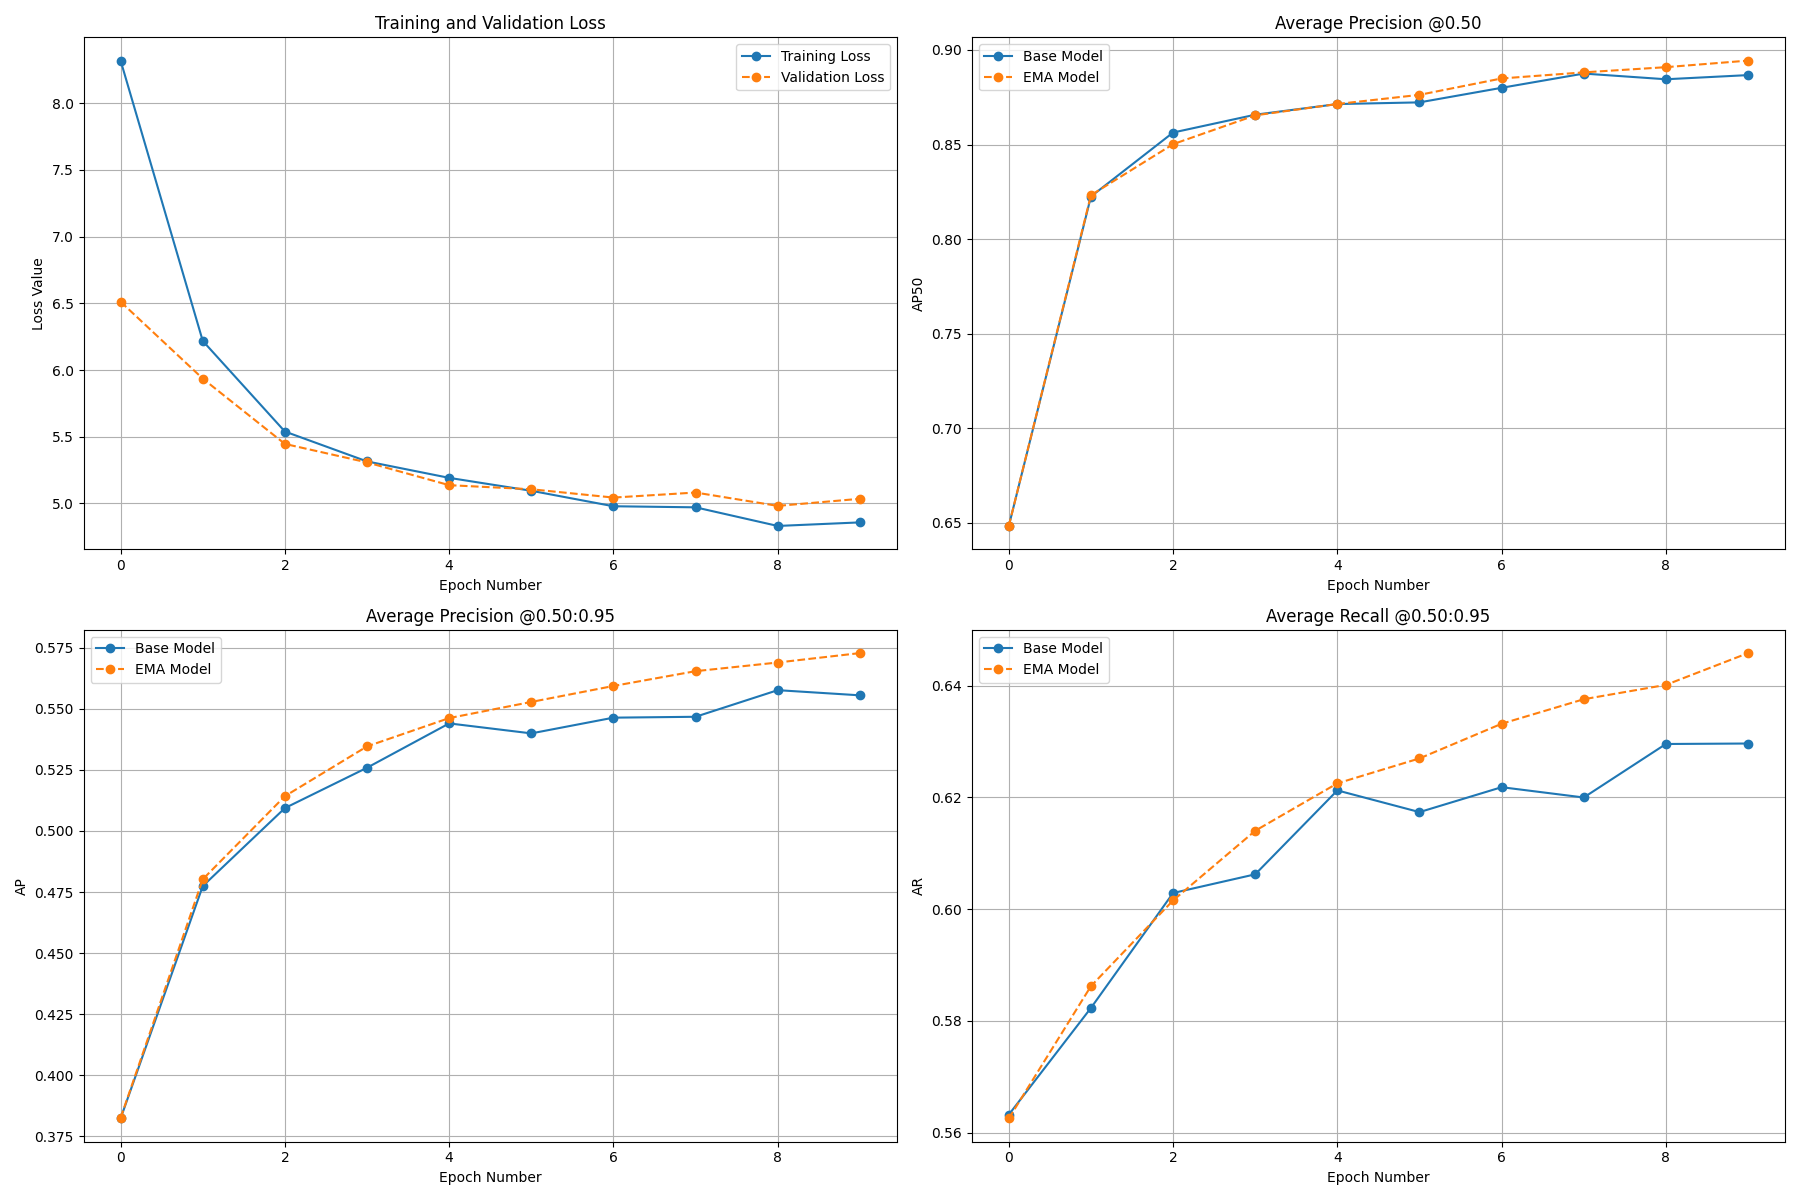

In [ ]:
from PIL import Image

Image.open("/content/output/metrics_plot.png")

In [ ]:
!ls -la /content/output

total 1959704
drwxr-xr-x 3 root root      4096 Aug  6 13:34 .
drwxr-xr-x 1 root root      4096 Aug  6 13:17 ..
-rw-r--r-- 1 root root 535040506 Aug  6 13:34 checkpoint0009.pth
-rw-r--r-- 1 root root 401311829 Aug  6 13:34 checkpoint_best_ema.pth
-rw-r--r-- 1 root root 401320041 Aug  6 13:25 checkpoint_best_regular.pth
-rw-r--r-- 1 root root 133737350 Aug  6 13:34 checkpoint_best_total.pth
-rw-r--r-- 1 root root 535030322 Aug  6 13:34 checkpoint.pth
drwxr-xr-x 2 root root      4096 Aug  6 13:19 eval
-rw-r--r-- 1 root root      4412 Aug  6 13:34 events.out.tfevents.1754486237.14154fd71cd6.1731.0
-rw-r--r-- 1 root root     80406 Aug  6 13:34 log.txt
-rw-r--r-- 1 root root    157277 Aug  6 13:34 metrics_plot.png
-rw-r--r-- 1 root root      1651 Aug  6 13:34 results.json


## Evaluate Fine-tuned RF-DETR Model

Before benchmarking the model, we need to load the best saved checkpoint. To ensure it fits on the GPU, we first need to free up GPU memory. This involves deleting any remaining references to previously used objects, triggering Python’s garbage collector, and clearing the CUDA memory cache.

In [ ]:
import gc
import torch
import weakref

def cleanup_gpu_memory(obj=None, verbose: bool = False):

    if not torch.cuda.is_available():
        if verbose:
            print("[INFO] CUDA is not available. No GPU cleanup needed.")
        return

    def get_memory_stats():
        allocated = torch.cuda.memory_allocated()
        reserved = torch.cuda.memory_reserved()
        return allocated, reserved

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[Before] Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

    # Ensure we drop all strong references
    if obj is not None:
        ref = weakref.ref(obj)
        del obj
        if ref() is not None and verbose:
            print("[WARNING] Object not fully garbage collected yet.")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[After]  Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

In [ ]:
cleanup_gpu_memory(model, verbose=True)

[Before] Allocated: 146.49 MB | Reserved: 10432.00 MB
[WARNING] Object not fully garbage collected yet.
[After]  Allocated: 146.49 MB | Reserved: 316.00 MB


We load the best-performing model from the `checkpoint_best_total.pth` file using the `RFDETRMedium` class. This checkpoint contains the trained weights from our most successful training run. After loading, we call `optimize_for_inference()`, which prepares the model for efficient inference.

In [23]:
from rfdetr import RFDETRNano
model = RFDETRNano(pretrain_weights="/content/your_destination_folder/Destination_Folder/output2/checkpoint_best_total.pth")
model.optimize_for_inference()

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


reinitializing detection head with 1 classes
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


In [24]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

In [28]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision
from PIL import Image

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 297/297 [00:12<00:00, 24.64it/s]


In [29]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()
print(map_result)

Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.924
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.999
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.989
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.620
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]                 = 0.915
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]                 = 0.992


## Run Inference with Fine-tuned RF-DETR Model

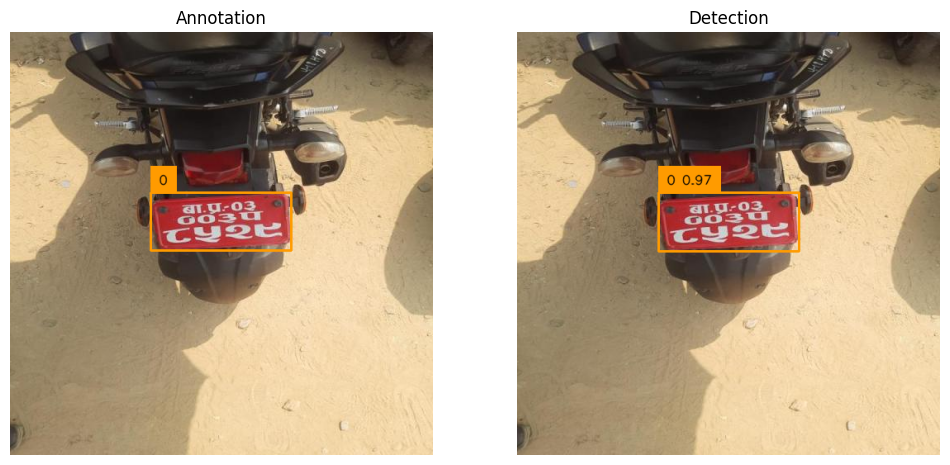

In [30]:
from rfdetr import RFDETRNano
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

detections = model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

bbox_annotator = sv.BoxAnnotator(color=color,thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import os

# Define source and destination paths
source_folder = '/content/drive/MyDrive/ojdai/results/Destination_Folder' # Replace with your actual folder path in Google Drive
destination_folder = '/content/your_destination_folder' # Replace with your desired destination in Colab

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Copy the folder using a shell command
!cp -r "{source_folder}" "{destination_folder}"

print(f"Folder copied from {source_folder} to {destination_folder}")

Folder copied from /content/drive/MyDrive/ojdai/results/Destination_Folder to /content/your_destination_folder


## Define Output Directories

### Subtask:
Create two new directories in the Colab environment: one for saving the fully annotated inference images and another for saving the cropped detected areas of bounding boxes.


**Reasoning**:
To create the specified directories, I will use the `os.makedirs()` function with `exist_ok=True` for both the annotated images directory and the cropped detections directory.



In [39]:
import os

ANNOTATED_IMAGES_DIR = "/content/annotated_images"
CROPPED_DETECTIONS_DIR = "/content/cropped_detections"

os.makedirs(ANNOTATED_IMAGES_DIR, exist_ok=True)
os.makedirs(CROPPED_DETECTIONS_DIR, exist_ok=True)

print(f"Created directory: {ANNOTATED_IMAGES_DIR}")
print(f"Created directory: {CROPPED_DETECTIONS_DIR}")

Created directory: /content/annotated_images
Created directory: /content/cropped_detections


**Reasoning**:
The previous step successfully created the output directories. The next step, according to the main task, is to develop a Python function to save annotated PIL Images to the `ANNOTATED_IMAGES_DIR`.



In [32]:
def save_annotated_image(image: Image.Image, filename: str):
    """
    Saves an annotated PIL Image to the ANNOTATED_IMAGES_DIR.

    Args:
        image (PIL.Image.Image): The annotated PIL Image to save.
        filename (str): The base filename (e.g., 'image.jpg') for the saved image.
    """
    save_path = os.path.join(ANNOTATED_IMAGES_DIR, filename)
    image.save(save_path)
    print(f"Saved annotated image to {save_path}")

print("Defined function: save_annotated_image")

Defined function: save_annotated_image


**Reasoning**:
The previous step defined a function to save annotated images. Now, I need to define a function that crops detected areas from an image and saves them to the `CROPPED_DETECTIONS_DIR` as specified in the main task.



In [33]:
def save_cropped_detections(image: Image.Image, detections: sv.Detections, base_filename: str):
    """
    Crops detected areas from an image and saves them to the CROPPED_DETECTIONS_DIR.

    Args:
        image (PIL.Image.Image): The original PIL Image.
        detections (sv.Detections): A Supervision Detections object containing bounding boxes.
        base_filename (str): The base filename (e.g., 'image.jpg') for the saved cropped images.
    """
    for i, (xyxy, confidence, class_id, tracker_id) in enumerate(detections):
        x_min, y_min, x_max, y_max = map(int, xyxy)
        cropped_image = image.crop((x_min, y_min, x_max, y_max))
        # Generate a unique filename for each cropped detection
        cropped_filename = f"{os.path.splitext(base_filename)[0]}_crop_{i}.png"
        save_path = os.path.join(CROPPED_DETECTIONS_DIR, cropped_filename)
        cropped_image.save(save_path)
        print(f"Saved cropped detection to {save_path}")

print("Defined function: save_cropped_detections")

Defined function: save_cropped_detections


In [35]:
def save_cropped_detections(image: Image.Image, detections: sv.Detections, base_filename: str):
    """
    Crops detected areas from an image and saves them to the CROPPED_DETECTIONS_DIR.

    Args:
        image (PIL.Image.Image): The original PIL Image.
        detections (sv.Detections): A Supervision Detections object containing bounding boxes.
        base_filename (str): The base filename (e.g., 'image.jpg') for the saved cropped images.
    """
    # Iterate through the detections by index to access xyxy
    for i in range(len(detections)):
        xyxy = detections.xyxy[i]
        x_min, y_min, x_max, y_max = map(int, xyxy)
        cropped_image = image.crop((x_min, y_min, x_max, y_max))
        # Generate a unique filename for each cropped detection
        cropped_filename = f"{os.path.splitext(base_filename)[0]}_crop_{i}.png"
        save_path = os.path.join(CROPPED_DETECTIONS_DIR, cropped_filename)
        cropped_image.save(save_path)
        print(f"Saved cropped detection to {save_path}")

print("Defined function: save_cropped_detections")

Defined function: save_cropped_detections


In [40]:
import supervision as sv
from PIL import Image
from tqdm import tqdm
import os
import time # Import the time module

# Ensure annotators and color palette are defined (as they were in previous cells)
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])
bbox_annotator = sv.BoxAnnotator(color=color)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK)

inference_times = [] # List to store inference times

for path, original_image_sv, _ in tqdm(ds, desc="Processing images for inference and saving results"):
    original_image_pil = Image.open(path)

    # Perform inference and measure time
    start_time = time.time()
    detections = model.predict(original_image_pil, threshold=0.5)
    end_time = time.time()
    inference_times.append(end_time - start_time)

    # Prepare labels for annotation
    labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    # Annotate the image
    annotated_image = original_image_pil.copy()
    annotated_image = bbox_annotator.annotate(annotated_image, detections)
    annotated_image = label_annotator.annotate(annotated_image, detections, labels)

    # Extract base filename from path
    base_filename = os.path.basename(path)

    # Save the full annotated image
    save_annotated_image(annotated_image, base_filename)

    # Save cropped detections
    save_cropped_detections(original_image_pil, detections, base_filename)

print("Finished processing all images, annotated images and cropped detections saved.")

# Calculate and print average inference speed
if inference_times:
    average_inference_time = sum(inference_times) / len(inference_times)
    print(f"\nAverage inference time per image: {average_inference_time:.4f} seconds")
    print(f"Average inference speed: {1 / average_inference_time:.2f} images/second")
else:
    print("No inferences were performed.")

Processing images for inference and saving results:   1%|▏         | 4/297 [00:00<00:15, 19.35it/s]

Saved annotated image to /content/annotated_images/20240505_111644_jpg.rf.e447760c2acabee7c7ab4b61a7d14449.jpg
Saved cropped detection to /content/cropped_detections/20240505_111644_jpg.rf.e447760c2acabee7c7ab4b61a7d14449_crop_0.png
Saved annotated image to /content/annotated_images/20240814_131836_jpg.rf.0214dee5d93f6d0e8bf2225b7065996a.jpg
Saved cropped detection to /content/cropped_detections/20240814_131836_jpg.rf.0214dee5d93f6d0e8bf2225b7065996a_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240502_093756_jpg.rf.8d63fa949248d62c58d91f4fde0df37f.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240502_093756_jpg.rf.8d63fa949248d62c58d91f4fde0df37f_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240814_141206_jpg.rf.fd4e3d5071f0abdb4b03bf32dd77ed08.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240814_141206_jpg.rf.fd4e3d5071f0abdb4b03bf32dd77ed08_crop_0.png


Processing images for inference and saving results:   3%|▎         | 9/297 [00:00<00:14, 19.84it/s]

Saved annotated image to /content/annotated_images/1714911343338_jpg.rf.900a0735f777124bb42e1519a6e5df92.jpg
Saved cropped detection to /content/cropped_detections/1714911343338_jpg.rf.900a0735f777124bb42e1519a6e5df92_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0487_jpg.rf.3e4c4b4fb5d8bd88d317eab3a3fa4ce2.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0487_jpg.rf.3e4c4b4fb5d8bd88d317eab3a3fa4ce2_crop_0.png
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0487_jpg.rf.3e4c4b4fb5d8bd88d317eab3a3fa4ce2_crop_1.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0629_jpg.rf.4b1d84b03bfccba2ae366c67ef0365b0.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0629_jpg.rf.4b1d84b03bfccba2ae366c67ef0365b0_crop_0.png
Saved annotated image to /content/annotated_images/FB_IMG_1722798639716_jpg.rf.0ee435cbc2eae9ec4e731806d14ac233.jpg
Saved cropped detection to /content/cropped_det

Processing images for inference and saving results:   4%|▍         | 12/297 [00:00<00:13, 20.49it/s]

Saved annotated image to /content/annotated_images/IMG-20240729-WA0334_jpg.rf.ceea48d0321c8dbabe6d33a7e88443a8.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0334_jpg.rf.ceea48d0321c8dbabe6d33a7e88443a8_crop_0.png
Saved annotated image to /content/annotated_images/Bikevalid46_jpg.rf.e37f6c63b156e3934c6c0b3312b626af.jpg
Saved cropped detection to /content/cropped_detections/Bikevalid46_jpg.rf.e37f6c63b156e3934c6c0b3312b626af_crop_0.png
Saved annotated image to /content/annotated_images/20240728_113816_jpg.rf.277e96d6fdae883c3ebd3f6c88146538.jpg
Saved cropped detection to /content/cropped_detections/20240728_113816_jpg.rf.277e96d6fdae883c3ebd3f6c88146538_crop_0.png
Saved annotated image to /content/annotated_images/20240608_120005_jpg.rf.7e00ce76538a85cda3f86377e349d151.jpg
Saved cropped detection to /content/cropped_detections/20240608_120005_jpg.rf.7e00ce76538a85cda3f86377e349d151_crop_0.png
Saved annotated image to /content/annotated_images/20240505_095613_j

Processing images for inference and saving results:   6%|▌         | 18/297 [00:00<00:13, 20.76it/s]

Saved annotated image to /content/annotated_images/Bikevalid81_jpg.rf.178b01667cda1ef6c0ed8e5a0303a2aa.jpg
Saved cropped detection to /content/cropped_detections/Bikevalid81_jpg.rf.178b01667cda1ef6c0ed8e5a0303a2aa_crop_0.png
Saved cropped detection to /content/cropped_detections/Bikevalid81_jpg.rf.178b01667cda1ef6c0ed8e5a0303a2aa_crop_1.png
Saved annotated image to /content/annotated_images/IMG_20240814_135132_jpg.rf.0a3cd13ccbad7bf7ebe9ef9e26f4a05d.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240814_135132_jpg.rf.0a3cd13ccbad7bf7ebe9ef9e26f4a05d_crop_0.png
Saved annotated image to /content/annotated_images/Screenshot_20240808_230354_Facebook_jpg.rf.f95f96e1d0c2d4483c66ab7a0eca6185.jpg
Saved cropped detection to /content/cropped_detections/Screenshot_20240808_230354_Facebook_jpg.rf.f95f96e1d0c2d4483c66ab7a0eca6185_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240804-WA0083_jpg.rf.87314428f74506950166b4ccb02122d1.jpg
Saved cropped detection to /

Processing images for inference and saving results:   8%|▊         | 24/297 [00:01<00:12, 22.01it/s]

Saved annotated image to /content/annotated_images/IMG-20240729-WA0083_jpg.rf.7dad343fc9fb3cd14beb51e22e4b3091.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0083_jpg.rf.7dad343fc9fb3cd14beb51e22e4b3091_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240804-WA0070_jpg.rf.9ba9cd5409c9eeb56fad7235e1d571a5.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240804-WA0070_jpg.rf.9ba9cd5409c9eeb56fad7235e1d571a5_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0032_jpg.rf.2c799a7b52503162834fbe73af82c9a2.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0032_jpg.rf.2c799a7b52503162834fbe73af82c9a2_crop_0.png
Saved annotated image to /content/annotated_images/20240428_074906_jpg.rf.be80c2abb39b561e919328af9f4f8693.jpg
Saved cropped detection to /content/cropped_detections/20240428_074906_jpg.rf.be80c2abb39b561e919328af9f4f8693_crop_0.png
Saved annotated image to /content/annotated_

Processing images for inference and saving results:   9%|▉         | 27/297 [00:01<00:12, 21.83it/s]

Saved annotated image to /content/annotated_images/20240608_113857_jpg.rf.3c6a2387fc4e9327f7eba190082d8e85.jpg
Saved cropped detection to /content/cropped_detections/20240608_113857_jpg.rf.3c6a2387fc4e9327f7eba190082d8e85_crop_0.png
Saved annotated image to /content/annotated_images/Bikevalid83_jpg.rf.7f1de94bd52f40a19545fd570e0ffc89.jpg
Saved cropped detection to /content/cropped_detections/Bikevalid83_jpg.rf.7f1de94bd52f40a19545fd570e0ffc89_crop_0.png
Saved annotated image to /content/annotated_images/1714911343859_jpg.rf.b038f7cb075ae9a42a027e3513f0c6de.jpg
Saved cropped detection to /content/cropped_detections/1714911343859_jpg.rf.b038f7cb075ae9a42a027e3513f0c6de_crop_0.png
Saved annotated image to /content/annotated_images/FB_IMG_1722829539918_jpg.rf.1a07d00c5f478857f00a1390ae6534c2.jpg
Saved cropped detection to /content/cropped_detections/FB_IMG_1722829539918_jpg.rf.1a07d00c5f478857f00a1390ae6534c2_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240814_135941

Processing images for inference and saving results:  11%|█         | 33/297 [00:01<00:12, 21.95it/s]

Saved annotated image to /content/annotated_images/20240721_144203_jpg.rf.65b5eb30e8eb8cb53496456e76c743d1.jpg
Saved cropped detection to /content/cropped_detections/20240721_144203_jpg.rf.65b5eb30e8eb8cb53496456e76c743d1_crop_0.png
Saved annotated image to /content/annotated_images/20240505_110519_jpg.rf.b31f8f60321c78fa25538a9bc8726327.jpg
Saved cropped detection to /content/cropped_detections/20240505_110519_jpg.rf.b31f8f60321c78fa25538a9bc8726327_crop_0.png
Saved annotated image to /content/annotated_images/Screenshot_20240808_112647_Facebook_jpg.rf.4d01aff734cf38592fa6b253ee652177.jpg
Saved cropped detection to /content/cropped_detections/Screenshot_20240808_112647_Facebook_jpg.rf.4d01aff734cf38592fa6b253ee652177_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240502_094343_jpg.rf.b0b1ec369b8cfaf8533b9632eef9cf03.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240502_094343_jpg.rf.b0b1ec369b8cfaf8533b9632eef9cf03_crop_0.png
Saved annotated imag

Processing images for inference and saving results:  13%|█▎        | 39/297 [00:01<00:11, 22.10it/s]

Saved annotated image to /content/annotated_images/IMG_20240814_135557_jpg.rf.afbf77f82087891803441254d1b724a2.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240814_135557_jpg.rf.afbf77f82087891803441254d1b724a2_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240814_135439_jpg.rf.3149e462032c4776426cb5582cac9d4c.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240814_135439_jpg.rf.3149e462032c4776426cb5582cac9d4c_crop_0.png
Saved annotated image to /content/annotated_images/FB_IMG_1722755483646_jpg.rf.73e066211042498f88258a4f381b84cd.jpg
Saved cropped detection to /content/cropped_detections/FB_IMG_1722755483646_jpg.rf.73e066211042498f88258a4f381b84cd_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240730-WA0110_jpg.rf.bcc0772810910f5ad93acd3f34210ade.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240730-WA0110_jpg.rf.bcc0772810910f5ad93acd3f34210ade_crop_0.png
Saved annotated image to /content/

Processing images for inference and saving results:  14%|█▍        | 42/297 [00:01<00:11, 21.36it/s]

Saved annotated image to /content/annotated_images/20240505_095641_jpg.rf.f479f8f44e5175b58e7fae27deb891a2.jpg
Saved cropped detection to /content/cropped_detections/20240505_095641_jpg.rf.f479f8f44e5175b58e7fae27deb891a2_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240814_141243_jpg.rf.1526ba3ff8f3f65c2018653581d77f2b.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240814_141243_jpg.rf.1526ba3ff8f3f65c2018653581d77f2b_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240814_141252_jpg.rf.81946100fc29a269ab62e4d56d32641d.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240814_141252_jpg.rf.81946100fc29a269ab62e4d56d32641d_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0339_jpg.rf.2326f76f0e62201f5c6b7a98a7baa05a.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0339_jpg.rf.2326f76f0e62201f5c6b7a98a7baa05a_crop_0.png
Saved annotated image to /content/annotated_

Processing images for inference and saving results:  16%|█▌        | 48/297 [00:02<00:11, 21.72it/s]

Saved annotated image to /content/annotated_images/20240505_110559_jpg.rf.9be569eaf82b056778c294b7fa363a7d.jpg
Saved cropped detection to /content/cropped_detections/20240505_110559_jpg.rf.9be569eaf82b056778c294b7fa363a7d_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240814_135258_jpg.rf.701840e80bdac1f6b6b79f67eb861df9.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240814_135258_jpg.rf.701840e80bdac1f6b6b79f67eb861df9_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240502_084935_jpg.rf.843f25ab0c454d34fa5f51a503444150.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240502_084935_jpg.rf.843f25ab0c454d34fa5f51a503444150_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0103_jpg.rf.3d88a1de5159509f99c9fa08b97e33e5.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0103_jpg.rf.3d88a1de5159509f99c9fa08b97e33e5_crop_0.png
Saved annotated image to /content/annotated_

Processing images for inference and saving results:  18%|█▊        | 54/297 [00:02<00:10, 22.98it/s]

Saved annotated image to /content/annotated_images/1714911346676_jpg.rf.8c25bc34be224f7274d00f28d2cc3da1.jpg
Saved cropped detection to /content/cropped_detections/1714911346676_jpg.rf.8c25bc34be224f7274d00f28d2cc3da1_crop_0.png
Saved annotated image to /content/annotated_images/20240722_133141_jpg.rf.0bd574e5233a63ec67512c0988541abb.jpg
Saved cropped detection to /content/cropped_detections/20240722_133141_jpg.rf.0bd574e5233a63ec67512c0988541abb_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0515_jpg.rf.5832423857266e2a39589576780c990c.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0515_jpg.rf.5832423857266e2a39589576780c990c_crop_0.png
Saved annotated image to /content/annotated_images/IMG_1140_jpg.rf.e1c8fe113be6e8967e5f638496dec54b.jpg
Saved cropped detection to /content/cropped_detections/IMG_1140_jpg.rf.e1c8fe113be6e8967e5f638496dec54b_crop_0.png
Saved annotated image to /content/annotated_images/carvalid89_jpg.rf.e660282fb

Processing images for inference and saving results:  20%|██        | 60/297 [00:02<00:09, 25.32it/s]

Saved annotated image to /content/annotated_images/20240505_112618_jpg.rf.789da454c98fbc3bc25f4117268fe41a.jpg
Saved cropped detection to /content/cropped_detections/20240505_112618_jpg.rf.789da454c98fbc3bc25f4117268fe41a_crop_0.png
Saved annotated image to /content/annotated_images/20240505_113204_jpg.rf.439b7bd5f6fcada1ae8779011ee281c4.jpg
Saved cropped detection to /content/cropped_detections/20240505_113204_jpg.rf.439b7bd5f6fcada1ae8779011ee281c4_crop_0.png
Saved annotated image to /content/annotated_images/20240505_112717_jpg.rf.9f7247d0738f045177d1b6b034720d74.jpg
Saved cropped detection to /content/cropped_detections/20240505_112717_jpg.rf.9f7247d0738f045177d1b6b034720d74_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0623_jpg.rf.c61e4bd9e408be3244fdb51815c13663.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0623_jpg.rf.c61e4bd9e408be3244fdb51815c13663_crop_0.png
Saved annotated image to /content/annotated_images/Screensho

Processing images for inference and saving results:  22%|██▏       | 66/297 [00:02<00:08, 27.38it/s]

Saved annotated image to /content/annotated_images/1714911348217_jpg.rf.0f35dfe5770d5517a3ce43293b828713.jpg
Saved cropped detection to /content/cropped_detections/1714911348217_jpg.rf.0f35dfe5770d5517a3ce43293b828713_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240814_140607_jpg.rf.0c41143832ae3af39a47ba61cb5eb7d7.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240814_140607_jpg.rf.0c41143832ae3af39a47ba61cb5eb7d7_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240814_140052_jpg.rf.f82317df357e78617cceb175dfe0ead8.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240814_140052_jpg.rf.f82317df357e78617cceb175dfe0ead8_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240502_094815_jpg.rf.7950e97354ee67f0ec1e182b2fbedece.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240502_094815_jpg.rf.7950e97354ee67f0ec1e182b2fbedece_crop_0.png
Saved annotated image to /content/annotated_imag

Processing images for inference and saving results:  25%|██▍       | 73/297 [00:03<00:07, 28.53it/s]

Saved annotated image to /content/annotated_images/IMG_1148_jpg.rf.2fafec5309d6c6042b07d6712ba144ee.jpg
Saved cropped detection to /content/cropped_detections/IMG_1148_jpg.rf.2fafec5309d6c6042b07d6712ba144ee_crop_0.png
Saved annotated image to /content/annotated_images/Screenshot_20240804_133506_Facebook_jpg.rf.bbbfef815944e4b86cb96c41282f3479.jpg
Saved cropped detection to /content/cropped_detections/Screenshot_20240804_133506_Facebook_jpg.rf.bbbfef815944e4b86cb96c41282f3479_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240813_231057_jpg.rf.7dedd61d5a1e1dc0a6405f839fbc6f98.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240813_231057_jpg.rf.7dedd61d5a1e1dc0a6405f839fbc6f98_crop_0.png
Saved annotated image to /content/annotated_images/Screenshot_20240814_002310_Facebook_jpg.rf.b526328dc5c4c37b024485aa12be0003.jpg
Saved cropped detection to /content/cropped_detections/Screenshot_20240814_002310_Facebook_jpg.rf.b526328dc5c4c37b024485aa12be0003_crop_

Processing images for inference and saving results:  27%|██▋       | 81/297 [00:03<00:07, 30.15it/s]

Saved annotated image to /content/annotated_images/carvalid127_jpg.rf.016c7c50842852dfd7d4c34d189f8aed.jpg
Saved cropped detection to /content/cropped_detections/carvalid127_jpg.rf.016c7c50842852dfd7d4c34d189f8aed_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240813_231402_jpg.rf.511f0881a794785dc64a1ddbb8158b3c.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240813_231402_jpg.rf.511f0881a794785dc64a1ddbb8158b3c_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0197_jpg.rf.0977fbb73eb97c748c54f3cc9ba42ef1.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0197_jpg.rf.0977fbb73eb97c748c54f3cc9ba42ef1_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0615_jpg.rf.24527aec4d38cf7e14fe33e629e5c58f.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0615_jpg.rf.24527aec4d38cf7e14fe33e629e5c58f_crop_0.png
Saved annotated image to /content/annotated_images/2

Processing images for inference and saving results:  29%|██▊       | 85/297 [00:03<00:06, 30.59it/s]

Saved annotated image to /content/annotated_images/Screenshot_20240814_000119_Facebook_jpg.rf.7c49fc081d3f7a0f0a38b7edad339730.jpg
Saved cropped detection to /content/cropped_detections/Screenshot_20240814_000119_Facebook_jpg.rf.7c49fc081d3f7a0f0a38b7edad339730_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240730-WA0022_jpg.rf.f54b893c13591517dc2ac82e7b2866b1.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240730-WA0022_jpg.rf.f54b893c13591517dc2ac82e7b2866b1_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240710_193121_183_jpg.rf.cd0049591da76edc29f7031977909007.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240710_193121_183_jpg.rf.cd0049591da76edc29f7031977909007_crop_0.png
Saved annotated image to /content/annotated_images/Screenshot_20240809_233346_Facebook_jpg.rf.2f63e5b6d0111634e8e2ab87f015d926.jpg
Saved cropped detection to /content/cropped_detections/Screenshot_20240809_233346_Facebook_jpg.rf.2f63e5b6

Processing images for inference and saving results:  31%|███▏      | 93/297 [00:03<00:06, 31.65it/s]

Saved annotated image to /content/annotated_images/IMG-20240729-WA0411_jpg.rf.d36a623e66d971a7faaadc02e72284c2.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0411_jpg.rf.d36a623e66d971a7faaadc02e72284c2_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240724-WA0013_jpg.rf.5736bd9ae0c19913175f3f0f95968583.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240724-WA0013_jpg.rf.5736bd9ae0c19913175f3f0f95968583_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240814_134357_jpg.rf.20a1ca09a420be724b72b2e8dcc0b1b3.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240814_134357_jpg.rf.20a1ca09a420be724b72b2e8dcc0b1b3_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0062_jpg.rf.ddac49e3998b2570afcb0d0d2868a275.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0062_jpg.rf.ddac49e3998b2570afcb0d0d2868a275_crop_0.png
Saved annotated image to /content/an

Processing images for inference and saving results:  34%|███▍      | 101/297 [00:04<00:06, 31.51it/s]

Saved annotated image to /content/annotated_images/IMG-20240729-WA0238_jpg.rf.56bde01e4dbdfd363d6e9453f7ce6810.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0238_jpg.rf.56bde01e4dbdfd363d6e9453f7ce6810_crop_0.png
Saved annotated image to /content/annotated_images/Screenshot_20240808_225125_Facebook_jpg.rf.b59a6599cec23f02dac01903b7ee9bdd.jpg
Saved cropped detection to /content/cropped_detections/Screenshot_20240808_225125_Facebook_jpg.rf.b59a6599cec23f02dac01903b7ee9bdd_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0421_jpg.rf.35f893a502ffc200c8958cc798d58543.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0421_jpg.rf.35f893a502ffc200c8958cc798d58543_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240814_135501_jpg.rf.1a9632eeca0d3f2181487926d8272331.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240814_135501_jpg.rf.1a9632eeca0d3f2181487926d8272331_crop_0.png
Save

Processing images for inference and saving results:  37%|███▋      | 109/297 [00:04<00:05, 32.32it/s]

Saved annotated image to /content/annotated_images/IMG-20240729-WA0431_jpg.rf.0ca0628e4bfec0c48f1b6e273a91257d.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0431_jpg.rf.0ca0628e4bfec0c48f1b6e273a91257d_crop_0.png
Saved annotated image to /content/annotated_images/Bikevalid89_jpg.rf.460e79bd33e58aff328c4082aaba2a69.jpg
Saved cropped detection to /content/cropped_detections/Bikevalid89_jpg.rf.460e79bd33e58aff328c4082aaba2a69_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0011_jpg.rf.247124bf3f827076408f42cd00a7e2b5.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0011_jpg.rf.247124bf3f827076408f42cd00a7e2b5_crop_0.png
Saved annotated image to /content/annotated_images/Bikevalid29_jpg.rf.678e510a331c7b43274fd4efe28b5958.jpg
Saved cropped detection to /content/cropped_detections/Bikevalid29_jpg.rf.678e510a331c7b43274fd4efe28b5958_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240814_1347

Processing images for inference and saving results:  38%|███▊      | 113/297 [00:04<00:05, 32.45it/s]

Saved annotated image to /content/annotated_images/20240805_114245_jpg.rf.6b3004910341d7da422cf17b44a380ab.jpg
Saved cropped detection to /content/cropped_detections/20240805_114245_jpg.rf.6b3004910341d7da422cf17b44a380ab_crop_0.png
Saved annotated image to /content/annotated_images/20240502_093810_jpg.rf.b3ea47e2be391720cffb12d36fcbc516.jpg
Saved cropped detection to /content/cropped_detections/20240502_093810_jpg.rf.b3ea47e2be391720cffb12d36fcbc516_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240814_135911_jpg.rf.06a3baa39be4c430cb46e9bce04759de.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240814_135911_jpg.rf.06a3baa39be4c430cb46e9bce04759de_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240502_085041_jpg.rf.4b9a743fc81f5fe177571e4adb8b2633.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240502_085041_jpg.rf.4b9a743fc81f5fe177571e4adb8b2633_crop_0.png
Saved annotated image to /content/annotated_images/I

Processing images for inference and saving results:  41%|████      | 121/297 [00:04<00:05, 31.58it/s]

Saved annotated image to /content/annotated_images/1714911344229_jpg.rf.2919112ede2e927859d3e14d65965ba4.jpg
Saved cropped detection to /content/cropped_detections/1714911344229_jpg.rf.2919112ede2e927859d3e14d65965ba4_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240813_231635_jpg.rf.45c94d5372016ed7372ce51b8ffd4264.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240813_231635_jpg.rf.45c94d5372016ed7372ce51b8ffd4264_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0063_jpg.rf.68dd5d3106c075d4d0513e39a1446cc0.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0063_jpg.rf.68dd5d3106c075d4d0513e39a1446cc0_crop_0.png
Saved annotated image to /content/annotated_images/20240505_111011_jpg.rf.ed04afcfd052f0496f4a04ccc157cbd2.jpg
Saved cropped detection to /content/cropped_detections/20240505_111011_jpg.rf.ed04afcfd052f0496f4a04ccc157cbd2_crop_0.png
Saved annotated image to /content/annotated_images/carva

Processing images for inference and saving results:  43%|████▎     | 129/297 [00:04<00:05, 31.52it/s]

Saved annotated image to /content/annotated_images/IMG-20240729-WA0237_jpg.rf.6a87ce735d20df93a78d121e063ac7e3.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0237_jpg.rf.6a87ce735d20df93a78d121e063ac7e3_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240502_095536_jpg.rf.5e29df67b66fab3bf0bf2283d42d130d.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240502_095536_jpg.rf.5e29df67b66fab3bf0bf2283d42d130d_crop_0.png
Saved annotated image to /content/annotated_images/1714911343298_jpg.rf.4e32e03a624517360865037cce5cd0e4.jpg
Saved cropped detection to /content/cropped_detections/1714911343298_jpg.rf.4e32e03a624517360865037cce5cd0e4_crop_0.png
Saved annotated image to /content/annotated_images/20240502_095249_jpg.rf.40cf2bf60ff25feb8dc644ea52f27d97.jpg
Saved cropped detection to /content/cropped_detections/20240502_095249_jpg.rf.40cf2bf60ff25feb8dc644ea52f27d97_crop_0.png
Saved annotated image to /content/annotated_images/IMG_2

Processing images for inference and saving results:  46%|████▌     | 137/297 [00:05<00:05, 31.18it/s]

Saved annotated image to /content/annotated_images/Bikevalid13_jpg.rf.884a788bce810aa385cf2953eaae32be.jpg
Saved cropped detection to /content/cropped_detections/Bikevalid13_jpg.rf.884a788bce810aa385cf2953eaae32be_crop_0.png
Saved cropped detection to /content/cropped_detections/Bikevalid13_jpg.rf.884a788bce810aa385cf2953eaae32be_crop_1.png
Saved annotated image to /content/annotated_images/Bikevalid75_jpg.rf.e3681bab6d2aca50018d10867eda4508.jpg
Saved cropped detection to /content/cropped_detections/Bikevalid75_jpg.rf.e3681bab6d2aca50018d10867eda4508_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0613_jpg.rf.a4458fd9f97d3ff384172aa21685d01f.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0613_jpg.rf.a4458fd9f97d3ff384172aa21685d01f_crop_0.png
Saved annotated image to /content/annotated_images/20240505_111346_jpg.rf.51b2d17030ae9f9f0299b38e66a5a601.jpg
Saved cropped detection to /content/cropped_detections/20240505_111346_jpg.rf.51

Processing images for inference and saving results:  47%|████▋     | 141/297 [00:05<00:05, 30.80it/s]

Saved annotated image to /content/annotated_images/1714911343876_jpg.rf.3b40fb979466159c70884e87d2abdf97.jpg
Saved cropped detection to /content/cropped_detections/1714911343876_jpg.rf.3b40fb979466159c70884e87d2abdf97_crop_0.png
Saved annotated image to /content/annotated_images/Bikevalid73_jpg.rf.d1fe1d653110c22c72010c168fc87661.jpg
Saved cropped detection to /content/cropped_detections/Bikevalid73_jpg.rf.d1fe1d653110c22c72010c168fc87661_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0072_jpg.rf.f605705d86a54e9ca26b070319e89073.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0072_jpg.rf.f605705d86a54e9ca26b070319e89073_crop_0.png
Saved annotated image to /content/annotated_images/IMG_1273_JPG.rf.5cbf4fd065c6dd88aa13faa64347b90e.jpg
Saved cropped detection to /content/cropped_detections/IMG_1273_JPG.rf.5cbf4fd065c6dd88aa13faa64347b90e_crop_0.png
Saved annotated image to /content/annotated_images/20240505_113145_jpg.rf.4384a21953ac

Processing images for inference and saving results:  50%|█████     | 149/297 [00:05<00:04, 30.74it/s]

Saved annotated image to /content/annotated_images/IMG_20240502_094924_jpg.rf.84c8d95a9374432efcc75f7633c0b5b9.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240502_094924_jpg.rf.84c8d95a9374432efcc75f7633c0b5b9_crop_0.png
Saved annotated image to /content/annotated_images/20240505_110426_jpg.rf.986c8cd9374abe2afe3a47736a705345.jpg
Saved cropped detection to /content/cropped_detections/20240505_110426_jpg.rf.986c8cd9374abe2afe3a47736a705345_crop_0.png
Saved annotated image to /content/annotated_images/20240505_111603_jpg.rf.bca56e6d43ae1f11e1f64ed108248591.jpg
Saved cropped detection to /content/cropped_detections/20240505_111603_jpg.rf.bca56e6d43ae1f11e1f64ed108248591_crop_0.png
Saved cropped detection to /content/cropped_detections/20240505_111603_jpg.rf.bca56e6d43ae1f11e1f64ed108248591_crop_1.png
Saved annotated image to /content/annotated_images/Bikevalid97_jpg.rf.2a54716a89e5cbe0e57a6883777165bb.jpg
Saved cropped detection to /content/cropped_detections/Bikevalid

Processing images for inference and saving results:  53%|█████▎    | 157/297 [00:05<00:04, 30.88it/s]

Saved cropped detection to /content/cropped_detections/IMG_20240502_095033_jpg.rf.d4f7de757d121a8dd605d83bf6f2dfb4_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240814_140112_jpg.rf.41e8d53259f1c5fd97b75fa14667c1e6.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240814_140112_jpg.rf.41e8d53259f1c5fd97b75fa14667c1e6_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0624_jpg.rf.543f536ef9f7245acb9bc5f8bc416fca.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0624_jpg.rf.543f536ef9f7245acb9bc5f8bc416fca_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240814_140739_jpg.rf.d98339a1b29e28c4551f7aa0f095e95a.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240814_140739_jpg.rf.d98339a1b29e28c4551f7aa0f095e95a_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240814_134216_jpg.rf.cfb3d7a0c50ef3baf81285d934bcd39f.jpg
Saved cropped detection to /content/

Processing images for inference and saving results:  54%|█████▍    | 161/297 [00:05<00:04, 31.30it/s]

Saved annotated image to /content/annotated_images/20240608_131307_jpg.rf.c65c1bd548af699ce46d7963d15f77cd.jpg
Saved cropped detection to /content/cropped_detections/20240608_131307_jpg.rf.c65c1bd548af699ce46d7963d15f77cd_crop_0.png
Saved annotated image to /content/annotated_images/1714911347058_jpg.rf.1745bd1ed6b947be776b308cfbb6739c.jpg
Saved cropped detection to /content/cropped_detections/1714911347058_jpg.rf.1745bd1ed6b947be776b308cfbb6739c_crop_0.png
Saved annotated image to /content/annotated_images/Bikevalid48_jpg.rf.9f9334a2c9f7315cfceb172ae0e03a11.jpg
Saved cropped detection to /content/cropped_detections/Bikevalid48_jpg.rf.9f9334a2c9f7315cfceb172ae0e03a11_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0216_jpg.rf.bf3b0279215aa2d2802b37bc5a054e2c.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0216_jpg.rf.bf3b0279215aa2d2802b37bc5a054e2c_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240502_084551_j

Processing images for inference and saving results:  57%|█████▋    | 169/297 [00:06<00:04, 31.20it/s]

Saved annotated image to /content/annotated_images/Bikevalid92_jpg.rf.d87e74c1efd8a2b00a0ed0961dbc8c87.jpg
Saved cropped detection to /content/cropped_detections/Bikevalid92_jpg.rf.d87e74c1efd8a2b00a0ed0961dbc8c87_crop_0.png
Saved annotated image to /content/annotated_images/Bikevalid68_jpg.rf.43aa0a0bf0a49f3b42e027294fc4ebf5.jpg
Saved cropped detection to /content/cropped_detections/Bikevalid68_jpg.rf.43aa0a0bf0a49f3b42e027294fc4ebf5_crop_0.png
Saved annotated image to /content/annotated_images/Screenshot_20240808_230407_Facebook_jpg.rf.6ea2f0e395222bffa0ecd18aa062c824.jpg
Saved cropped detection to /content/cropped_detections/Screenshot_20240808_230407_Facebook_jpg.rf.6ea2f0e395222bffa0ecd18aa062c824_crop_0.png
Saved annotated image to /content/annotated_images/20240505_104542_jpg.rf.fbf5648a6f9e6f2d7fe72be6731cc8c2.jpg
Saved cropped detection to /content/cropped_detections/20240505_104542_jpg.rf.fbf5648a6f9e6f2d7fe72be6731cc8c2_crop_0.png
Saved annotated image to /content/annotated_

Processing images for inference and saving results:  60%|█████▉    | 177/297 [00:06<00:03, 30.51it/s]

Saved cropped detection to /content/cropped_detections/IMG_1162_jpg.rf.79a9a648286fd07eebcc459a8067d427_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0190_jpg.rf.2516c3d0fb3f8937fb86eaf65bbc947d.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0190_jpg.rf.2516c3d0fb3f8937fb86eaf65bbc947d_crop_0.png
Saved annotated image to /content/annotated_images/20240505_110452_jpg.rf.b3097ed329a8a9ff1d4c304169309469.jpg
Saved cropped detection to /content/cropped_detections/20240505_110452_jpg.rf.b3097ed329a8a9ff1d4c304169309469_crop_0.png
Saved cropped detection to /content/cropped_detections/20240505_110452_jpg.rf.b3097ed329a8a9ff1d4c304169309469_crop_1.png
Saved annotated image to /content/annotated_images/20240505_110957_jpg.rf.83e3d7dce398437fde26c1238a2829ef.jpg
Saved cropped detection to /content/cropped_detections/20240505_110957_jpg.rf.83e3d7dce398437fde26c1238a2829ef_crop_0.png
Saved annotated image to /content/annotated_images/IMG_2

Processing images for inference and saving results:  61%|██████    | 181/297 [00:06<00:03, 30.84it/s]

Saved annotated image to /content/annotated_images/carvalid73_jpg.rf.a4b707cc81fdbc089aa274573de3b0b5.jpg
Saved cropped detection to /content/cropped_detections/carvalid73_jpg.rf.a4b707cc81fdbc089aa274573de3b0b5_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240428_075309_jpg.rf.3b0c9deb13de768c02a2187224e6038b.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240428_075309_jpg.rf.3b0c9deb13de768c02a2187224e6038b_crop_0.png
Saved cropped detection to /content/cropped_detections/IMG_20240428_075309_jpg.rf.3b0c9deb13de768c02a2187224e6038b_crop_1.png
Saved annotated image to /content/annotated_images/20240505_095622_jpg.rf.7b18297e7e7b03d6e28b5b092c03375d.jpg
Saved cropped detection to /content/cropped_detections/20240505_095622_jpg.rf.7b18297e7e7b03d6e28b5b092c03375d_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240730-WA0074_jpg.rf.6e2f03825f6274f0d817c94e6a7c8c3f.jpg
Saved cropped detection to /content/cropped_detections/IMG-202

Processing images for inference and saving results:  64%|██████▎   | 189/297 [00:06<00:03, 31.35it/s]

Saved annotated image to /content/annotated_images/IMG_20240502_084613_jpg.rf.51c94c4bfcb77c6e762dc29449cfabf7.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240502_084613_jpg.rf.51c94c4bfcb77c6e762dc29449cfabf7_crop_0.png
Saved annotated image to /content/annotated_images/Screenshot_20240811_111026_Facebook_jpg.rf.025e0a0864f53be6b3a0c632b5ac3188.jpg
Saved cropped detection to /content/cropped_detections/Screenshot_20240811_111026_Facebook_jpg.rf.025e0a0864f53be6b3a0c632b5ac3188_crop_0.png
Saved annotated image to /content/annotated_images/FB_IMG_1723143210282_jpg.rf.ee797a9d8b817e3969ebf7d699684959.jpg
Saved cropped detection to /content/cropped_detections/FB_IMG_1723143210282_jpg.rf.ee797a9d8b817e3969ebf7d699684959_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240813_231039_jpg.rf.e7f437b4e2e05b2d53da38c3395854ad.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240813_231039_jpg.rf.e7f437b4e2e05b2d53da38c3395854ad_crop_0.png
Sa

Processing images for inference and saving results:  66%|██████▋   | 197/297 [00:07<00:03, 30.92it/s]

Saved annotated image to /content/annotated_images/20240505_110903_jpg.rf.31cc9acfe307cbe293b31d14fcadd968.jpg
Saved cropped detection to /content/cropped_detections/20240505_110903_jpg.rf.31cc9acfe307cbe293b31d14fcadd968_crop_0.png
Saved annotated image to /content/annotated_images/20240505_095636_jpg.rf.f75c394f8daafca67124164d9d1b4ed6.jpg
Saved cropped detection to /content/cropped_detections/20240505_095636_jpg.rf.f75c394f8daafca67124164d9d1b4ed6_crop_0.png
Saved annotated image to /content/annotated_images/FB_IMG_1723483346221_jpg.rf.0d24223f594554a38c633f52e7ab1063.jpg
Saved cropped detection to /content/cropped_detections/FB_IMG_1723483346221_jpg.rf.0d24223f594554a38c633f52e7ab1063_crop_0.png
Saved annotated image to /content/annotated_images/FB_IMG_1722798734806_jpg.rf.b357b164d5a5070290ac4889678146d5.jpg
Saved cropped detection to /content/cropped_detections/FB_IMG_1722798734806_jpg.rf.b357b164d5a5070290ac4889678146d5_crop_0.png
Saved annotated image to /content/annotated_imag

Processing images for inference and saving results:  68%|██████▊   | 201/297 [00:07<00:03, 30.18it/s]

Saved annotated image to /content/annotated_images/IMG_20240814_140626_jpg.rf.016c58e5c6b839ed81320b3fdb7c06db.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240814_140626_jpg.rf.016c58e5c6b839ed81320b3fdb7c06db_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0056_jpg.rf.945958ba6bffe33784d7c4de3ad00cdb.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0056_jpg.rf.945958ba6bffe33784d7c4de3ad00cdb_crop_0.png
Saved annotated image to /content/annotated_images/carvalid81_jpg.rf.914e851a4ccd697988a51aa5a271e5e2.jpg
Saved cropped detection to /content/cropped_detections/carvalid81_jpg.rf.914e851a4ccd697988a51aa5a271e5e2_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0179_jpg.rf.524eaafb1690dc491f4da37801dd04e3.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0179_jpg.rf.524eaafb1690dc491f4da37801dd04e3_crop_0.png
Saved annotated image to /content/annotated_images/171

Processing images for inference and saving results:  70%|███████   | 209/297 [00:07<00:02, 30.09it/s]

Saved annotated image to /content/annotated_images/IMG-20240729-WA0064_jpg.rf.8fc0a5918f739eb3701c5d471f38ded2.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0064_jpg.rf.8fc0a5918f739eb3701c5d471f38ded2_crop_0.png
Saved annotated image to /content/annotated_images/carvalid105_jpg.rf.69213cddf53857c3ca498098e766db56.jpg
Saved cropped detection to /content/cropped_detections/carvalid105_jpg.rf.69213cddf53857c3ca498098e766db56_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240813_231624_jpg.rf.335989acd64132aa3d634c9dbaecae25.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240813_231624_jpg.rf.335989acd64132aa3d634c9dbaecae25_crop_0.png
Saved annotated image to /content/annotated_images/Bikevalid77_jpg.rf.391a3d9d209ea61b2cdbb4146162fe9d.jpg
Saved cropped detection to /content/cropped_detections/Bikevalid77_jpg.rf.391a3d9d209ea61b2cdbb4146162fe9d_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240814_1349

Processing images for inference and saving results:  73%|███████▎  | 216/297 [00:07<00:02, 28.87it/s]

Saved annotated image to /content/annotated_images/IMG-20240729-WA0181_jpg.rf.733a409d73359b8114ce4fa763ab4eab.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0181_jpg.rf.733a409d73359b8114ce4fa763ab4eab_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240814_140723_jpg.rf.ee731d803a056df2a5b2376d864260ef.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240814_140723_jpg.rf.ee731d803a056df2a5b2376d864260ef_crop_0.png
Saved annotated image to /content/annotated_images/20240505_095431_jpg.rf.2b3e7ca9922b81922d3f668025a6fbdb.jpg
Saved cropped detection to /content/cropped_detections/20240505_095431_jpg.rf.2b3e7ca9922b81922d3f668025a6fbdb_crop_0.png
Saved cropped detection to /content/cropped_detections/20240505_095431_jpg.rf.2b3e7ca9922b81922d3f668025a6fbdb_crop_1.png
Saved annotated image to /content/annotated_images/IMG_20240429_101949_jpg.rf.9586619fc222b89e1c1198c09af5dc68.jpg
Saved cropped detection to /content/cropped_dete

Processing images for inference and saving results:  75%|███████▍  | 222/297 [00:07<00:02, 29.23it/s]

Saved annotated image to /content/annotated_images/IMG-20240729-WA0111_jpg.rf.a73edde27e1c7ce362807a80125dabaa.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0111_jpg.rf.a73edde27e1c7ce362807a80125dabaa_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0121_jpg.rf.d0687c021fab5a250daf59b5a594457d.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0121_jpg.rf.d0687c021fab5a250daf59b5a594457d_crop_0.png
Saved annotated image to /content/annotated_images/20240505_113131_jpg.rf.e955e66b04285afd10bf6e0e7f143836.jpg
Saved cropped detection to /content/cropped_detections/20240505_113131_jpg.rf.e955e66b04285afd10bf6e0e7f143836_crop_0.png
Saved annotated image to /content/annotated_images/20240505_111838_jpg.rf.4fc6b645b1da81d28290580c6322097d.jpg
Saved cropped detection to /content/cropped_detections/20240505_111838_jpg.rf.4fc6b645b1da81d28290580c6322097d_crop_0.png
Saved annotated image to /content/annotated_images/I

Processing images for inference and saving results:  76%|███████▌  | 226/297 [00:08<00:02, 29.89it/s]

Saved annotated image to /content/annotated_images/IMG-20240730-WA0102_jpg.rf.6fa20122f9bdef812fa8ee57d3dd7752.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240730-WA0102_jpg.rf.6fa20122f9bdef812fa8ee57d3dd7752_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240814_141318_jpg.rf.8e1be0dfd6876856fbf1d778db1bc16d.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240814_141318_jpg.rf.8e1be0dfd6876856fbf1d778db1bc16d_crop_0.png
Saved annotated image to /content/annotated_images/carvalid18_jpg.rf.2e84150c8f5e1d35790994ffbba16578.jpg
Saved cropped detection to /content/cropped_detections/carvalid18_jpg.rf.2e84150c8f5e1d35790994ffbba16578_crop_0.png
Saved cropped detection to /content/cropped_detections/carvalid18_jpg.rf.2e84150c8f5e1d35790994ffbba16578_crop_1.png
Saved annotated image to /content/annotated_images/carvalid8_jpg.rf.8ec32008f19fc4bb28d0d8792ab9602b.jpg
Saved cropped detection to /content/cropped_detections/carvalid8_jpg.rf.8

Processing images for inference and saving results:  78%|███████▊  | 233/297 [00:08<00:02, 29.76it/s]

Saved annotated image to /content/annotated_images/FB_IMG_1723608726288_jpg.rf.4e6bdea4cceda530b14edf6a6d28797c.jpg
Saved cropped detection to /content/cropped_detections/FB_IMG_1723608726288_jpg.rf.4e6bdea4cceda530b14edf6a6d28797c_crop_0.png
Saved annotated image to /content/annotated_images/FB_IMG_1723541800451_jpg.rf.90b1a5f566cc14198e8bb3352b533df4.jpg
Saved cropped detection to /content/cropped_detections/FB_IMG_1723541800451_jpg.rf.90b1a5f566cc14198e8bb3352b533df4_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240814_140529_jpg.rf.1f6d998596933782c51607fc867373d5.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240814_140529_jpg.rf.1f6d998596933782c51607fc867373d5_crop_0.png
Saved annotated image to /content/annotated_images/Screenshot_20240812_114509_Facebook_jpg.rf.21d1f9d0acb0688ed36aeca4c720608a.jpg
Saved cropped detection to /content/cropped_detections/Screenshot_20240812_114509_Facebook_jpg.rf.21d1f9d0acb0688ed36aeca4c720608a_crop_0.png


Processing images for inference and saving results:  81%|████████  | 241/297 [00:08<00:01, 30.34it/s]

Saved annotated image to /content/annotated_images/carvalid55_jpg.rf.eb364b3b5edbf22fe03cc5db571dfa34.jpg
Saved cropped detection to /content/cropped_detections/carvalid55_jpg.rf.eb364b3b5edbf22fe03cc5db571dfa34_crop_0.png
Saved annotated image to /content/annotated_images/carvalid13_jpg.rf.6b4934fa9ffb757c80c5ae0f21855068.jpg
Saved cropped detection to /content/cropped_detections/carvalid13_jpg.rf.6b4934fa9ffb757c80c5ae0f21855068_crop_0.png
Saved annotated image to /content/annotated_images/carvalid114_jpg.rf.a0d6e2a3fe794847041820f31a16a1b5.jpg
Saved cropped detection to /content/cropped_detections/carvalid114_jpg.rf.a0d6e2a3fe794847041820f31a16a1b5_crop_0.png
Saved annotated image to /content/annotated_images/IMG_1138_jpg.rf.c9693a04044032eca93f83b613680528.jpg
Saved cropped detection to /content/cropped_detections/IMG_1138_jpg.rf.c9693a04044032eca93f83b613680528_crop_0.png
Saved annotated image to /content/annotated_images/carvalid35_jpg.rf.d5f204984befa7480e7c40631c18d597.jpg
Save

Processing images for inference and saving results:  84%|████████▍ | 249/297 [00:08<00:01, 31.26it/s]

Saved annotated image to /content/annotated_images/20240814_131731_jpg.rf.a700a3dfa1e2a75951cd61cad3f7c9cb.jpg
Saved cropped detection to /content/cropped_detections/20240814_131731_jpg.rf.a700a3dfa1e2a75951cd61cad3f7c9cb_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240814_135745_jpg.rf.e9d8f4bf08694f8b7192488d4c646b38.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240814_135745_jpg.rf.e9d8f4bf08694f8b7192488d4c646b38_crop_0.png
Saved annotated image to /content/annotated_images/20240502_092956_jpg.rf.9464a9e78b0b177f6ae9fe6a89765ef8.jpg
Saved cropped detection to /content/cropped_detections/20240502_092956_jpg.rf.9464a9e78b0b177f6ae9fe6a89765ef8_crop_0.png
Saved annotated image to /content/annotated_images/1714911349242_jpg.rf.3a1059ed90171817cd22512897c40c7e.jpg
Saved cropped detection to /content/cropped_detections/1714911349242_jpg.rf.3a1059ed90171817cd22512897c40c7e_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-

Processing images for inference and saving results:  85%|████████▌ | 253/297 [00:08<00:01, 31.49it/s]

Saved annotated image to /content/annotated_images/Screenshot_20240809_233338_Facebook_jpg.rf.b4e8bfaf3f1c45e9f6e1d03cbc04ea10.jpg
Saved cropped detection to /content/cropped_detections/Screenshot_20240809_233338_Facebook_jpg.rf.b4e8bfaf3f1c45e9f6e1d03cbc04ea10_crop_0.png
Saved cropped detection to /content/cropped_detections/Screenshot_20240809_233338_Facebook_jpg.rf.b4e8bfaf3f1c45e9f6e1d03cbc04ea10_crop_1.png
Saved annotated image to /content/annotated_images/IMG_1144_jpg.rf.e563a9eb53127fe16e473f118a40f858.jpg
Saved cropped detection to /content/cropped_detections/IMG_1144_jpg.rf.e563a9eb53127fe16e473f118a40f858_crop_0.png
Saved annotated image to /content/annotated_images/20240801_105549_jpg.rf.e006ceb4ac7f33921d3412b5d90f1044.jpg
Saved cropped detection to /content/cropped_detections/20240801_105549_jpg.rf.e006ceb4ac7f33921d3412b5d90f1044_crop_0.png
Saved cropped detection to /content/cropped_detections/20240801_105549_jpg.rf.e006ceb4ac7f33921d3412b5d90f1044_crop_1.png
Saved cropp

Processing images for inference and saving results:  88%|████████▊ | 261/297 [00:09<00:01, 30.82it/s]

Saved annotated image to /content/annotated_images/20240502_095012_jpg.rf.9760dd39a86b39d7b1aa528be519a317.jpg
Saved cropped detection to /content/cropped_detections/20240502_095012_jpg.rf.9760dd39a86b39d7b1aa528be519a317_crop_0.png
Saved cropped detection to /content/cropped_detections/20240502_095012_jpg.rf.9760dd39a86b39d7b1aa528be519a317_crop_1.png
Saved annotated image to /content/annotated_images/Screenshot_20240814_000323_Facebook_jpg.rf.374a36cc13694d5236eca53d9b14bb9c.jpg
Saved cropped detection to /content/cropped_detections/Screenshot_20240814_000323_Facebook_jpg.rf.374a36cc13694d5236eca53d9b14bb9c_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0101_jpg.rf.ad6881b32ae1a8becda55771017c6bea.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0101_jpg.rf.ad6881b32ae1a8becda55771017c6bea_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240804-WA0024_jpg.rf.d9e8b0a03ac68346a3e3173213b94af4.jpg
Saved cropped de

Processing images for inference and saving results:  91%|█████████ | 269/297 [00:09<00:00, 31.56it/s]

Saved annotated image to /content/annotated_images/IMG-20240805-WA0011_jpg.rf.fc745bd986f9881993e1c997fad0f4ae.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240805-WA0011_jpg.rf.fc745bd986f9881993e1c997fad0f4ae_crop_0.png
Saved annotated image to /content/annotated_images/VideoCapture_20240608-161243_jpg.rf.98bdbe6f4769003c5361794b651018ba.jpg
Saved cropped detection to /content/cropped_detections/VideoCapture_20240608-161243_jpg.rf.98bdbe6f4769003c5361794b651018ba_crop_0.png
Saved annotated image to /content/annotated_images/Screenshot_20240814_000159_Facebook_jpg.rf.1cd58abc0b3345138152ff6c90eff054.jpg
Saved cropped detection to /content/cropped_detections/Screenshot_20240814_000159_Facebook_jpg.rf.1cd58abc0b3345138152ff6c90eff054_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0054_jpg.rf.d77d9f61840505a96f11d1cc39fe8c07.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0054_jpg.rf.d77d9f61840505a96f11d1cc39fe8c

Processing images for inference and saving results:  92%|█████████▏| 273/297 [00:09<00:00, 30.75it/s]

Saved annotated image to /content/annotated_images/20240502_093136_jpg.rf.5f854d86cfa541c757eb4ceb858ec006.jpg
Saved cropped detection to /content/cropped_detections/20240502_093136_jpg.rf.5f854d86cfa541c757eb4ceb858ec006_crop_0.png
Saved annotated image to /content/annotated_images/1714911349498_jpg.rf.e77f9bbbe3cbc382a61f13f927171289.jpg
Saved cropped detection to /content/cropped_detections/1714911349498_jpg.rf.e77f9bbbe3cbc382a61f13f927171289_crop_0.png
Saved annotated image to /content/annotated_images/Bikevalid7_jpg.rf.eabd47a9605f5bb5b9267cd34eaf7a57.jpg
Saved cropped detection to /content/cropped_detections/Bikevalid7_jpg.rf.eabd47a9605f5bb5b9267cd34eaf7a57_crop_0.png
Saved cropped detection to /content/cropped_detections/Bikevalid7_jpg.rf.eabd47a9605f5bb5b9267cd34eaf7a57_crop_1.png
Saved annotated image to /content/annotated_images/IMG_20240814_140021_jpg.rf.096fa34525893bc27cba6a49b7e866ec.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240814_140021_jpg.rf.0

Processing images for inference and saving results:  95%|█████████▍| 281/297 [00:09<00:00, 31.07it/s]

Saved annotated image to /content/annotated_images/IMG-20240729-WA0069_jpg.rf.48b43d2a421355128b63865ab0b96dea.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0069_jpg.rf.48b43d2a421355128b63865ab0b96dea_crop_0.png
Saved annotated image to /content/annotated_images/carvalid16_jpg.rf.348f40ecf93f27124a8588bd4857eba8.jpg
Saved cropped detection to /content/cropped_detections/carvalid16_jpg.rf.348f40ecf93f27124a8588bd4857eba8_crop_0.png
Saved annotated image to /content/annotated_images/carvalid131_jpg.rf.b40f24b97c01be3fc04d9b022102974c.jpg
Saved cropped detection to /content/cropped_detections/carvalid131_jpg.rf.b40f24b97c01be3fc04d9b022102974c_crop_0.png
Saved annotated image to /content/annotated_images/Screenshot_20240808_230437_Facebook_jpg.rf.08471a8f3d9d822a72b25527a55a4b83.jpg
Saved cropped detection to /content/cropped_detections/Screenshot_20240808_230437_Facebook_jpg.rf.08471a8f3d9d822a72b25527a55a4b83_crop_0.png
Saved annotated image to /content/anno

Processing images for inference and saving results:  97%|█████████▋| 289/297 [00:10<00:00, 31.61it/s]

Saved annotated image to /content/annotated_images/IMG_20240502_094649_jpg.rf.f49bdd6ce4fffb9dcbcabeff06223ac8.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240502_094649_jpg.rf.f49bdd6ce4fffb9dcbcabeff06223ac8_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0067_jpg.rf.b265067cc6caf8855b20d2d5c0e7c7ba.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0067_jpg.rf.b265067cc6caf8855b20d2d5c0e7c7ba_crop_0.png
Saved annotated image to /content/annotated_images/Bikevalid14_jpg.rf.ebc59b7896fd6839ee3d1acc86dcf5ce.jpg
Saved cropped detection to /content/cropped_detections/Bikevalid14_jpg.rf.ebc59b7896fd6839ee3d1acc86dcf5ce_crop_0.png
Saved annotated image to /content/annotated_images/20240505_112957_jpg.rf.7cf0fe58b0206d3261b9a35dc568893b.jpg
Saved cropped detection to /content/cropped_detections/20240505_112957_jpg.rf.7cf0fe58b0206d3261b9a35dc568893b_crop_0.png
Saved annotated image to /content/annotated_images/171491134

Processing images for inference and saving results:  99%|█████████▊| 293/297 [00:10<00:00, 31.09it/s]

Saved annotated image to /content/annotated_images/Screenshot_20240809_170055_Facebook_jpg.rf.6c44d51514ebf38ba1108383730898fa.jpg
Saved cropped detection to /content/cropped_detections/Screenshot_20240809_170055_Facebook_jpg.rf.6c44d51514ebf38ba1108383730898fa_crop_0.png
Saved annotated image to /content/annotated_images/1714911344762_jpg.rf.6effadea93b5f30c8f1140363158b777.jpg
Saved cropped detection to /content/cropped_detections/1714911344762_jpg.rf.6effadea93b5f30c8f1140363158b777_crop_0.png
Saved annotated image to /content/annotated_images/IMG-20240729-WA0052_jpg.rf.b91867d1cded7e6fd8e12af1d3ef684e.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0052_jpg.rf.b91867d1cded7e6fd8e12af1d3ef684e_crop_0.png
Saved annotated image to /content/annotated_images/IMG_20240429_094405_jpg.rf.038391838b8022cac683800cd63317d3.jpg
Saved cropped detection to /content/cropped_detections/IMG_20240429_094405_jpg.rf.038391838b8022cac683800cd63317d3_crop_0.png
Saved annotated 

Processing images for inference and saving results: 100%|██████████| 297/297 [00:10<00:00, 28.56it/s]

Saved annotated image to /content/annotated_images/IMG-20240729-WA0026_jpg.rf.c21d6e6b872c81e141f316c8284b5b85.jpg
Saved cropped detection to /content/cropped_detections/IMG-20240729-WA0026_jpg.rf.c21d6e6b872c81e141f316c8284b5b85_crop_0.png
Finished processing all images, annotated images and cropped detections saved.

Average inference time per image: 0.0247 seconds
Average inference speed: 40.48 images/second


**Reasoning**:
The code has been successfully re-executed with the corrected `save_cropped_detections` function. All images from the test dataset have been processed, and their annotated versions and cropped detections saved to the specified directories.



In [44]:

character = "/content/character"
character_detection = "/content/character_detection"

os.makedirs(character, exist_ok=True)
os.makedirs(character_detection, exist_ok=True)

print(f"Created directory: {character}")
print(f"Created directory: {character_detection}")

Created directory: /content/character
Created directory: /content/character_detection


In [57]:
import supervision as sv # Import supervision to get ds.classes length if ds is not already defined

# Assuming ds is already defined and loaded with the correct classes from your dataset.
# If ds is not yet defined, you might need to run the dataset loading cell (xm-lmRWLswO4) first.
# len(ds.classes) will give the correct number of classes (6 in your case).
model = RFDETRNano(pretrain_weights="/content/your_destination_folder/Destination_Folder/checkpoint_best_total.pth", num_classes=34)

model.optimize_for_inference()

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


In [60]:
import supervision as sv
from PIL import Image
from tqdm import tqdm
import os
import time

def save_annotated_image(image: Image.Image, filename: str, output_dir: str):
    """
    Saves an annotated PIL Image to the specified output directory.

    Args:
        image (PIL.Image.Image): The annotated PIL Image to save.
        filename (str): The base filename (e.g., 'image.jpg') for the saved image.
        output_dir (str): The directory where the image should be saved.
    """
    os.makedirs(output_dir, exist_ok=True) # Ensure directory exists right before saving
    save_path = os.path.join(output_dir, filename)
    image.save(save_path)
    print(f"Saved annotated image to {save_path}")

def save_cropped_detections(image: Image.Image, detections: sv.Detections, base_filename: str, output_dir: str):
    """
    Crops detected areas from an image and saves them to the specified output directory.

    Args:
        image (PIL.Image.Image): The original PIL Image.
        detections (sv.Detections): A Supervision Detections object containing bounding boxes.
        base_filename (str): The base filename (e.g., 'image.jpg') for the saved cropped images.
        output_dir (str): The directory where the cropped images should be saved.
    """
    os.makedirs(output_dir, exist_ok=True) # Ensure directory exists right before saving
    # Iterate through the detections by index to access xyxy
    for i in range(len(detections)):
        xyxy = detections.xyxy[i]
        x_min, y_min, x_max, y_max = map(int, xyxy)
        cropped_image = image.crop((x_min, y_min, x_max, y_max))
        # Generate a unique filename for each cropped detection
        cropped_filename = f"{os.path.splitext(base_filename)[0]}_crop_{i}.png"
        save_path = os.path.join(output_dir, cropped_filename)
        cropped_image.save(save_path)
        print(f"Saved cropped detection to {save_path}")

# --- Configure your custom image folder here ---
CUSTOM_IMAGE_FOLDER = '/content/cropped_detections' # <--- IMPORTANT: Update this path to your folder!

# Create the custom image folder if it doesn't exist (or ensure it's where your images are)
os.makedirs(CUSTOM_IMAGE_FOLDER, exist_ok=True)

# Ensure annotators and color palette are defined (re-using previous definitions if available)
# If you intend to use different colors or styles, you can redefine them here.
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])
bbox_annotator = sv.BoxAnnotator(color=color)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK)

inference_times = []
processed_count = 0

# Hardcode num_ds_classes to 34 as requested by the user
num_ds_classes = 34
print(f"Number of classes for labeling (hardcoded): {num_ds_classes}")

# Get a list of image files from the custom folder
image_files = [f for f in os.listdir(CUSTOM_IMAGE_FOLDER) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if not image_files:
    print(f"No image files found in {CUSTOM_IMAGE_FOLDER}. Please check the path and folder contents.")
else:
    for filename in tqdm(image_files, desc=f"Processing images from {CUSTOM_IMAGE_FOLDER}"):
        image_path = os.path.join(CUSTOM_IMAGE_FOLDER, filename)
        original_image_pil = Image.open(image_path)

        # Perform inference and measure time
        start_time = time.time()
        detections = model.predict(original_image_pil, threshold=0.5)
        end_time = time.time()
        inference_times.append(end_time - start_time)

        # Prepare labels for annotation, handling potential out-of-bounds class_id
        labels = []
        for class_id, confidence in zip(detections.class_id, detections.confidence):
            # Ensure class_id is within the bounds of actual ds.classes for name lookup
            if 0 <= class_id < len(ds.classes):
                labels.append(f"{ds.classes[class_id]} {confidence:.2f}")
            elif 0 <= class_id < num_ds_classes:
                # If class_id is within the hardcoded num_ds_classes but outside ds.classes
                labels.append(f"UNKNOWN_CLASS_{class_id} {confidence:.2f}")
            else:
                # Catch-all for class_id completely out of expected range
                labels.append(f"OUT_OF_BOUND_CLASS_{class_id} {confidence:.2f}")

        # Annotate the image
        annotated_image = original_image_pil.copy()
        annotated_image = bbox_annotator.annotate(annotated_image, detections)
        annotated_image = label_annotator.annotate(annotated_image, detections, labels)

        # Extract base filename from path
        base_filename = os.path.basename(path)

        # Save the full annotated image to the new character_detection directory
        save_annotated_image(annotated_image, filename, output_dir='/content/character_detection')

        # Save cropped detections to the new character directory
        save_cropped_detections(original_image_pil, detections, filename, output_dir='/content/character')
        processed_count += 1

    print("Finished processing all images, annotated images and cropped detections saved.")

    # Calculate and print average inference speed
    if inference_times:
        average_inference_time = sum(inference_times) / len(inference_times)
        print(f"\nAverage inference time per image: {average_inference_time:.4f} seconds")
        print(f"Average inference speed: {1 / average_inference_time:.2f} images/second")
    else:
        print("No inferences were performed.")

Number of classes for labeling (hardcoded): 34


Processing images from /content/cropped_detections:   1%|▏         | 4/316 [00:00<00:09, 31.83it/s]

Saved annotated image to /content/character_detection/IMG-20240729-WA0271_jpg.rf.24c410cf3d47cbf6faf6e2a9109b950f_crop_0.png
Saved cropped detection to /content/character/IMG-20240729-WA0271_jpg.rf.24c410cf3d47cbf6faf6e2a9109b950f_crop_0_crop_0.png
Saved cropped detection to /content/character/IMG-20240729-WA0271_jpg.rf.24c410cf3d47cbf6faf6e2a9109b950f_crop_0_crop_1.png
Saved cropped detection to /content/character/IMG-20240729-WA0271_jpg.rf.24c410cf3d47cbf6faf6e2a9109b950f_crop_0_crop_2.png
Saved cropped detection to /content/character/IMG-20240729-WA0271_jpg.rf.24c410cf3d47cbf6faf6e2a9109b950f_crop_0_crop_3.png
Saved cropped detection to /content/character/IMG-20240729-WA0271_jpg.rf.24c410cf3d47cbf6faf6e2a9109b950f_crop_0_crop_4.png
Saved cropped detection to /content/character/IMG-20240729-WA0271_jpg.rf.24c410cf3d47cbf6faf6e2a9109b950f_crop_0_crop_5.png
Saved cropped detection to /content/character/IMG-20240729-WA0271_jpg.rf.24c410cf3d47cbf6faf6e2a9109b950f_crop_0_crop_6.png
Saved a

Processing images from /content/cropped_detections:   4%|▍         | 13/316 [00:00<00:08, 36.91it/s]

Saved annotated image to /content/character_detection/Bikevalid89_jpg.rf.460e79bd33e58aff328c4082aaba2a69_crop_0.png
Saved cropped detection to /content/character/Bikevalid89_jpg.rf.460e79bd33e58aff328c4082aaba2a69_crop_0_crop_0.png
Saved cropped detection to /content/character/Bikevalid89_jpg.rf.460e79bd33e58aff328c4082aaba2a69_crop_0_crop_1.png
Saved cropped detection to /content/character/Bikevalid89_jpg.rf.460e79bd33e58aff328c4082aaba2a69_crop_0_crop_2.png
Saved cropped detection to /content/character/Bikevalid89_jpg.rf.460e79bd33e58aff328c4082aaba2a69_crop_0_crop_3.png
Saved cropped detection to /content/character/Bikevalid89_jpg.rf.460e79bd33e58aff328c4082aaba2a69_crop_0_crop_4.png
Saved cropped detection to /content/character/Bikevalid89_jpg.rf.460e79bd33e58aff328c4082aaba2a69_crop_0_crop_5.png
Saved annotated image to /content/character_detection/IMG-20240729-WA0487_jpg.rf.3e4c4b4fb5d8bd88d317eab3a3fa4ce2_crop_1.png
Saved annotated image to /content/character_detection/Screensh

Processing images from /content/cropped_detections:   7%|▋         | 23/316 [00:00<00:07, 40.30it/s]

Saved annotated image to /content/character_detection/20240502_095236_jpg.rf.4c27859b145e69228c46118421b0d349_crop_0.png
Saved cropped detection to /content/character/20240502_095236_jpg.rf.4c27859b145e69228c46118421b0d349_crop_0_crop_0.png
Saved cropped detection to /content/character/20240502_095236_jpg.rf.4c27859b145e69228c46118421b0d349_crop_0_crop_1.png
Saved cropped detection to /content/character/20240502_095236_jpg.rf.4c27859b145e69228c46118421b0d349_crop_0_crop_2.png
Saved cropped detection to /content/character/20240502_095236_jpg.rf.4c27859b145e69228c46118421b0d349_crop_0_crop_3.png
Saved cropped detection to /content/character/20240502_095236_jpg.rf.4c27859b145e69228c46118421b0d349_crop_0_crop_4.png
Saved cropped detection to /content/character/20240502_095236_jpg.rf.4c27859b145e69228c46118421b0d349_crop_0_crop_5.png
Saved cropped detection to /content/character/20240502_095236_jpg.rf.4c27859b145e69228c46118421b0d349_crop_0_crop_6.png
Saved cropped detection to /content/cha

Processing images from /content/cropped_detections:  11%|█         | 34/316 [00:00<00:06, 45.32it/s]

Saved annotated image to /content/character_detection/carvalid97_jpg.rf.af1b2274873bfd3fab8a24838509add1_crop_1.png
Saved cropped detection to /content/character/carvalid97_jpg.rf.af1b2274873bfd3fab8a24838509add1_crop_1_crop_0.png
Saved cropped detection to /content/character/carvalid97_jpg.rf.af1b2274873bfd3fab8a24838509add1_crop_1_crop_1.png
Saved annotated image to /content/character_detection/IMG_20240813_231635_jpg.rf.45c94d5372016ed7372ce51b8ffd4264_crop_0.png
Saved cropped detection to /content/character/IMG_20240813_231635_jpg.rf.45c94d5372016ed7372ce51b8ffd4264_crop_0_crop_0.png
Saved cropped detection to /content/character/IMG_20240813_231635_jpg.rf.45c94d5372016ed7372ce51b8ffd4264_crop_0_crop_1.png
Saved cropped detection to /content/character/IMG_20240813_231635_jpg.rf.45c94d5372016ed7372ce51b8ffd4264_crop_0_crop_2.png
Saved cropped detection to /content/character/IMG_20240813_231635_jpg.rf.45c94d5372016ed7372ce51b8ffd4264_crop_0_crop_3.png
Saved cropped detection to /conte

Processing images from /content/cropped_detections:  14%|█▍        | 45/316 [00:01<00:05, 48.34it/s]

Saved annotated image to /content/character_detection/Screenshot_20240808_230437_Facebook_jpg.rf.08471a8f3d9d822a72b25527a55a4b83_crop_0.png
Saved cropped detection to /content/character/Screenshot_20240808_230437_Facebook_jpg.rf.08471a8f3d9d822a72b25527a55a4b83_crop_0_crop_0.png
Saved cropped detection to /content/character/Screenshot_20240808_230437_Facebook_jpg.rf.08471a8f3d9d822a72b25527a55a4b83_crop_0_crop_1.png
Saved cropped detection to /content/character/Screenshot_20240808_230437_Facebook_jpg.rf.08471a8f3d9d822a72b25527a55a4b83_crop_0_crop_2.png
Saved cropped detection to /content/character/Screenshot_20240808_230437_Facebook_jpg.rf.08471a8f3d9d822a72b25527a55a4b83_crop_0_crop_3.png
Saved cropped detection to /content/character/Screenshot_20240808_230437_Facebook_jpg.rf.08471a8f3d9d822a72b25527a55a4b83_crop_0_crop_4.png
Saved cropped detection to /content/character/Screenshot_20240808_230437_Facebook_jpg.rf.08471a8f3d9d822a72b25527a55a4b83_crop_0_crop_5.png
Saved cropped detec

Processing images from /content/cropped_detections:  17%|█▋        | 55/316 [00:01<00:05, 46.67it/s]

Saved annotated image to /content/character_detection/IMG_1140_jpg.rf.e1c8fe113be6e8967e5f638496dec54b_crop_0.png
Saved cropped detection to /content/character/IMG_1140_jpg.rf.e1c8fe113be6e8967e5f638496dec54b_crop_0_crop_0.png
Saved cropped detection to /content/character/IMG_1140_jpg.rf.e1c8fe113be6e8967e5f638496dec54b_crop_0_crop_1.png
Saved cropped detection to /content/character/IMG_1140_jpg.rf.e1c8fe113be6e8967e5f638496dec54b_crop_0_crop_2.png
Saved cropped detection to /content/character/IMG_1140_jpg.rf.e1c8fe113be6e8967e5f638496dec54b_crop_0_crop_3.png
Saved cropped detection to /content/character/IMG_1140_jpg.rf.e1c8fe113be6e8967e5f638496dec54b_crop_0_crop_4.png
Saved cropped detection to /content/character/IMG_1140_jpg.rf.e1c8fe113be6e8967e5f638496dec54b_crop_0_crop_5.png
Saved cropped detection to /content/character/IMG_1140_jpg.rf.e1c8fe113be6e8967e5f638496dec54b_crop_0_crop_6.png
Saved cropped detection to /content/character/IMG_1140_jpg.rf.e1c8fe113be6e8967e5f638496dec54b_

Processing images from /content/cropped_detections:  21%|██        | 65/316 [00:01<00:05, 47.49it/s]

Saved annotated image to /content/character_detection/Screenshot_20240809_233338_Facebook_jpg.rf.b4e8bfaf3f1c45e9f6e1d03cbc04ea10_crop_1.png
Saved annotated image to /content/character_detection/Bikevalid77_jpg.rf.391a3d9d209ea61b2cdbb4146162fe9d_crop_0.png
Saved cropped detection to /content/character/Bikevalid77_jpg.rf.391a3d9d209ea61b2cdbb4146162fe9d_crop_0_crop_0.png
Saved cropped detection to /content/character/Bikevalid77_jpg.rf.391a3d9d209ea61b2cdbb4146162fe9d_crop_0_crop_1.png
Saved cropped detection to /content/character/Bikevalid77_jpg.rf.391a3d9d209ea61b2cdbb4146162fe9d_crop_0_crop_2.png
Saved cropped detection to /content/character/Bikevalid77_jpg.rf.391a3d9d209ea61b2cdbb4146162fe9d_crop_0_crop_3.png
Saved cropped detection to /content/character/Bikevalid77_jpg.rf.391a3d9d209ea61b2cdbb4146162fe9d_crop_0_crop_4.png
Saved cropped detection to /content/character/Bikevalid77_jpg.rf.391a3d9d209ea61b2cdbb4146162fe9d_crop_0_crop_5.png
Saved cropped detection to /content/character/

Processing images from /content/cropped_detections:  24%|██▎       | 75/316 [00:01<00:05, 46.92it/s]

Saved annotated image to /content/character_detection/Screenshot_20240814_000323_Facebook_jpg.rf.374a36cc13694d5236eca53d9b14bb9c_crop_0.png
Saved cropped detection to /content/character/Screenshot_20240814_000323_Facebook_jpg.rf.374a36cc13694d5236eca53d9b14bb9c_crop_0_crop_0.png
Saved cropped detection to /content/character/Screenshot_20240814_000323_Facebook_jpg.rf.374a36cc13694d5236eca53d9b14bb9c_crop_0_crop_1.png
Saved cropped detection to /content/character/Screenshot_20240814_000323_Facebook_jpg.rf.374a36cc13694d5236eca53d9b14bb9c_crop_0_crop_2.png
Saved cropped detection to /content/character/Screenshot_20240814_000323_Facebook_jpg.rf.374a36cc13694d5236eca53d9b14bb9c_crop_0_crop_3.png
Saved cropped detection to /content/character/Screenshot_20240814_000323_Facebook_jpg.rf.374a36cc13694d5236eca53d9b14bb9c_crop_0_crop_4.png
Saved cropped detection to /content/character/Screenshot_20240814_000323_Facebook_jpg.rf.374a36cc13694d5236eca53d9b14bb9c_crop_0_crop_5.png
Saved cropped detec

Processing images from /content/cropped_detections:  27%|██▋       | 86/316 [00:01<00:04, 48.32it/s]

Saved cropped detection to /content/character/1714911344183_jpg.rf.04eb069c6f07a85b6c34eca48ca5870e_crop_0_crop_8.png
Saved cropped detection to /content/character/1714911344183_jpg.rf.04eb069c6f07a85b6c34eca48ca5870e_crop_0_crop_9.png
Saved cropped detection to /content/character/1714911344183_jpg.rf.04eb069c6f07a85b6c34eca48ca5870e_crop_0_crop_10.png
Saved cropped detection to /content/character/1714911344183_jpg.rf.04eb069c6f07a85b6c34eca48ca5870e_crop_0_crop_11.png
Saved annotated image to /content/character_detection/IMG_1148_jpg.rf.2fafec5309d6c6042b07d6712ba144ee_crop_0.png
Saved cropped detection to /content/character/IMG_1148_jpg.rf.2fafec5309d6c6042b07d6712ba144ee_crop_0_crop_0.png
Saved cropped detection to /content/character/IMG_1148_jpg.rf.2fafec5309d6c6042b07d6712ba144ee_crop_0_crop_1.png
Saved cropped detection to /content/character/IMG_1148_jpg.rf.2fafec5309d6c6042b07d6712ba144ee_crop_0_crop_2.png
Saved cropped detection to /content/character/IMG_1148_jpg.rf.2fafec5309d

Processing images from /content/cropped_detections:  29%|██▉       | 91/316 [00:02<00:04, 46.35it/s]

Saved annotated image to /content/character_detection/IMG_20240813_231603_jpg.rf.6a1fccd1ce2a58b7607993a6813bde34_crop_0.png
Saved cropped detection to /content/character/IMG_20240813_231603_jpg.rf.6a1fccd1ce2a58b7607993a6813bde34_crop_0_crop_0.png
Saved cropped detection to /content/character/IMG_20240813_231603_jpg.rf.6a1fccd1ce2a58b7607993a6813bde34_crop_0_crop_1.png
Saved cropped detection to /content/character/IMG_20240813_231603_jpg.rf.6a1fccd1ce2a58b7607993a6813bde34_crop_0_crop_2.png
Saved cropped detection to /content/character/IMG_20240813_231603_jpg.rf.6a1fccd1ce2a58b7607993a6813bde34_crop_0_crop_3.png
Saved cropped detection to /content/character/IMG_20240813_231603_jpg.rf.6a1fccd1ce2a58b7607993a6813bde34_crop_0_crop_4.png
Saved cropped detection to /content/character/IMG_20240813_231603_jpg.rf.6a1fccd1ce2a58b7607993a6813bde34_crop_0_crop_5.png
Saved cropped detection to /content/character/IMG_20240813_231603_jpg.rf.6a1fccd1ce2a58b7607993a6813bde34_crop_0_crop_6.png
Saved c

Processing images from /content/cropped_detections:  32%|███▏      | 101/316 [00:02<00:04, 46.91it/s]

Saved annotated image to /content/character_detection/carvalid35_jpg.rf.d5f204984befa7480e7c40631c18d597_crop_0.png
Saved cropped detection to /content/character/carvalid35_jpg.rf.d5f204984befa7480e7c40631c18d597_crop_0_crop_0.png
Saved cropped detection to /content/character/carvalid35_jpg.rf.d5f204984befa7480e7c40631c18d597_crop_0_crop_1.png
Saved cropped detection to /content/character/carvalid35_jpg.rf.d5f204984befa7480e7c40631c18d597_crop_0_crop_2.png
Saved cropped detection to /content/character/carvalid35_jpg.rf.d5f204984befa7480e7c40631c18d597_crop_0_crop_3.png
Saved cropped detection to /content/character/carvalid35_jpg.rf.d5f204984befa7480e7c40631c18d597_crop_0_crop_4.png
Saved cropped detection to /content/character/carvalid35_jpg.rf.d5f204984befa7480e7c40631c18d597_crop_0_crop_5.png
Saved cropped detection to /content/character/carvalid35_jpg.rf.d5f204984befa7480e7c40631c18d597_crop_0_crop_6.png
Saved cropped detection to /content/character/carvalid35_jpg.rf.d5f204984befa74

Processing images from /content/cropped_detections:  35%|███▌      | 111/316 [00:02<00:04, 47.90it/s]

Saved annotated image to /content/character_detection/IMG-20240729-WA0111_jpg.rf.a73edde27e1c7ce362807a80125dabaa_crop_0.png
Saved cropped detection to /content/character/IMG-20240729-WA0111_jpg.rf.a73edde27e1c7ce362807a80125dabaa_crop_0_crop_0.png
Saved cropped detection to /content/character/IMG-20240729-WA0111_jpg.rf.a73edde27e1c7ce362807a80125dabaa_crop_0_crop_1.png
Saved cropped detection to /content/character/IMG-20240729-WA0111_jpg.rf.a73edde27e1c7ce362807a80125dabaa_crop_0_crop_2.png
Saved cropped detection to /content/character/IMG-20240729-WA0111_jpg.rf.a73edde27e1c7ce362807a80125dabaa_crop_0_crop_3.png
Saved cropped detection to /content/character/IMG-20240729-WA0111_jpg.rf.a73edde27e1c7ce362807a80125dabaa_crop_0_crop_4.png
Saved cropped detection to /content/character/IMG-20240729-WA0111_jpg.rf.a73edde27e1c7ce362807a80125dabaa_crop_0_crop_5.png
Saved cropped detection to /content/character/IMG-20240729-WA0111_jpg.rf.a73edde27e1c7ce362807a80125dabaa_crop_0_crop_6.png
Saved a

Processing images from /content/cropped_detections:  38%|███▊      | 121/316 [00:02<00:04, 45.16it/s]

Saved annotated image to /content/character_detection/20240502_093136_jpg.rf.5f854d86cfa541c757eb4ceb858ec006_crop_0.png
Saved cropped detection to /content/character/20240502_093136_jpg.rf.5f854d86cfa541c757eb4ceb858ec006_crop_0_crop_0.png
Saved cropped detection to /content/character/20240502_093136_jpg.rf.5f854d86cfa541c757eb4ceb858ec006_crop_0_crop_1.png
Saved cropped detection to /content/character/20240502_093136_jpg.rf.5f854d86cfa541c757eb4ceb858ec006_crop_0_crop_2.png
Saved cropped detection to /content/character/20240502_093136_jpg.rf.5f854d86cfa541c757eb4ceb858ec006_crop_0_crop_3.png
Saved cropped detection to /content/character/20240502_093136_jpg.rf.5f854d86cfa541c757eb4ceb858ec006_crop_0_crop_4.png
Saved cropped detection to /content/character/20240502_093136_jpg.rf.5f854d86cfa541c757eb4ceb858ec006_crop_0_crop_5.png
Saved cropped detection to /content/character/20240502_093136_jpg.rf.5f854d86cfa541c757eb4ceb858ec006_crop_0_crop_6.png
Saved cropped detection to /content/cha

Processing images from /content/cropped_detections:  42%|████▏     | 133/316 [00:02<00:03, 48.92it/s]

Saved annotated image to /content/character_detection/Bikevalid7_jpg.rf.eabd47a9605f5bb5b9267cd34eaf7a57_crop_0.png
Saved cropped detection to /content/character/Bikevalid7_jpg.rf.eabd47a9605f5bb5b9267cd34eaf7a57_crop_0_crop_0.png
Saved cropped detection to /content/character/Bikevalid7_jpg.rf.eabd47a9605f5bb5b9267cd34eaf7a57_crop_0_crop_1.png
Saved cropped detection to /content/character/Bikevalid7_jpg.rf.eabd47a9605f5bb5b9267cd34eaf7a57_crop_0_crop_2.png
Saved cropped detection to /content/character/Bikevalid7_jpg.rf.eabd47a9605f5bb5b9267cd34eaf7a57_crop_0_crop_3.png
Saved cropped detection to /content/character/Bikevalid7_jpg.rf.eabd47a9605f5bb5b9267cd34eaf7a57_crop_0_crop_4.png
Saved cropped detection to /content/character/Bikevalid7_jpg.rf.eabd47a9605f5bb5b9267cd34eaf7a57_crop_0_crop_5.png
Saved annotated image to /content/character_detection/IMG_1185_jpg.rf.6280cd7f9b61e7d58b3199aedb6efb71_crop_0.png
Saved annotated image to /content/character_detection/IMG-20240729-WA0334_jpg.rf

Processing images from /content/cropped_detections:  46%|████▌     | 144/316 [00:03<00:03, 48.41it/s]

Saved annotated image to /content/character_detection/IMG_20240814_133921_jpg.rf.e9c37651003c6ecfce0dcf217e1473b9_crop_0.png
Saved cropped detection to /content/character/IMG_20240814_133921_jpg.rf.e9c37651003c6ecfce0dcf217e1473b9_crop_0_crop_0.png
Saved cropped detection to /content/character/IMG_20240814_133921_jpg.rf.e9c37651003c6ecfce0dcf217e1473b9_crop_0_crop_1.png
Saved cropped detection to /content/character/IMG_20240814_133921_jpg.rf.e9c37651003c6ecfce0dcf217e1473b9_crop_0_crop_2.png
Saved cropped detection to /content/character/IMG_20240814_133921_jpg.rf.e9c37651003c6ecfce0dcf217e1473b9_crop_0_crop_3.png
Saved cropped detection to /content/character/IMG_20240814_133921_jpg.rf.e9c37651003c6ecfce0dcf217e1473b9_crop_0_crop_4.png
Saved cropped detection to /content/character/IMG_20240814_133921_jpg.rf.e9c37651003c6ecfce0dcf217e1473b9_crop_0_crop_5.png
Saved cropped detection to /content/character/IMG_20240814_133921_jpg.rf.e9c37651003c6ecfce0dcf217e1473b9_crop_0_crop_6.png
Saved c

Processing images from /content/cropped_detections:  49%|████▊     | 154/316 [00:03<00:03, 47.42it/s]

Saved annotated image to /content/character_detection/20240811_115043_jpg.rf.c8ea20c77ba317fad225abca5d374c1a_crop_1.png
Saved cropped detection to /content/character/20240811_115043_jpg.rf.c8ea20c77ba317fad225abca5d374c1a_crop_1_crop_0.png
Saved cropped detection to /content/character/20240811_115043_jpg.rf.c8ea20c77ba317fad225abca5d374c1a_crop_1_crop_1.png
Saved cropped detection to /content/character/20240811_115043_jpg.rf.c8ea20c77ba317fad225abca5d374c1a_crop_1_crop_2.png
Saved cropped detection to /content/character/20240811_115043_jpg.rf.c8ea20c77ba317fad225abca5d374c1a_crop_1_crop_3.png
Saved annotated image to /content/character_detection/1714911347058_jpg.rf.1745bd1ed6b947be776b308cfbb6739c_crop_0.png
Saved cropped detection to /content/character/1714911347058_jpg.rf.1745bd1ed6b947be776b308cfbb6739c_crop_0_crop_0.png
Saved cropped detection to /content/character/1714911347058_jpg.rf.1745bd1ed6b947be776b308cfbb6739c_crop_0_crop_1.png
Saved cropped detection to /content/characte

Processing images from /content/cropped_detections:  52%|█████▏    | 165/316 [00:03<00:03, 47.35it/s]

Saved annotated image to /content/character_detection/Screenshot_20240814_002310_Facebook_jpg.rf.b526328dc5c4c37b024485aa12be0003_crop_0.png
Saved cropped detection to /content/character/Screenshot_20240814_002310_Facebook_jpg.rf.b526328dc5c4c37b024485aa12be0003_crop_0_crop_0.png
Saved cropped detection to /content/character/Screenshot_20240814_002310_Facebook_jpg.rf.b526328dc5c4c37b024485aa12be0003_crop_0_crop_1.png
Saved cropped detection to /content/character/Screenshot_20240814_002310_Facebook_jpg.rf.b526328dc5c4c37b024485aa12be0003_crop_0_crop_2.png
Saved cropped detection to /content/character/Screenshot_20240814_002310_Facebook_jpg.rf.b526328dc5c4c37b024485aa12be0003_crop_0_crop_3.png
Saved cropped detection to /content/character/Screenshot_20240814_002310_Facebook_jpg.rf.b526328dc5c4c37b024485aa12be0003_crop_0_crop_4.png
Saved cropped detection to /content/character/Screenshot_20240814_002310_Facebook_jpg.rf.b526328dc5c4c37b024485aa12be0003_crop_0_crop_5.png
Saved cropped detec

Processing images from /content/cropped_detections:  55%|█████▌    | 175/316 [00:03<00:03, 46.97it/s]

Saved annotated image to /content/character_detection/20240505_095636_jpg.rf.f75c394f8daafca67124164d9d1b4ed6_crop_0.png
Saved cropped detection to /content/character/20240505_095636_jpg.rf.f75c394f8daafca67124164d9d1b4ed6_crop_0_crop_0.png
Saved cropped detection to /content/character/20240505_095636_jpg.rf.f75c394f8daafca67124164d9d1b4ed6_crop_0_crop_1.png
Saved cropped detection to /content/character/20240505_095636_jpg.rf.f75c394f8daafca67124164d9d1b4ed6_crop_0_crop_2.png
Saved cropped detection to /content/character/20240505_095636_jpg.rf.f75c394f8daafca67124164d9d1b4ed6_crop_0_crop_3.png
Saved cropped detection to /content/character/20240505_095636_jpg.rf.f75c394f8daafca67124164d9d1b4ed6_crop_0_crop_4.png
Saved cropped detection to /content/character/20240505_095636_jpg.rf.f75c394f8daafca67124164d9d1b4ed6_crop_0_crop_5.png
Saved cropped detection to /content/character/20240505_095636_jpg.rf.f75c394f8daafca67124164d9d1b4ed6_crop_0_crop_6.png
Saved cropped detection to /content/cha

Processing images from /content/cropped_detections:  59%|█████▉    | 186/316 [00:04<00:02, 49.01it/s]

Saved annotated image to /content/character_detection/20240505_112929_jpg.rf.993a6f2bbcf9d01bb08a41e4e8a2d654_crop_0.png
Saved cropped detection to /content/character/20240505_112929_jpg.rf.993a6f2bbcf9d01bb08a41e4e8a2d654_crop_0_crop_0.png
Saved cropped detection to /content/character/20240505_112929_jpg.rf.993a6f2bbcf9d01bb08a41e4e8a2d654_crop_0_crop_1.png
Saved cropped detection to /content/character/20240505_112929_jpg.rf.993a6f2bbcf9d01bb08a41e4e8a2d654_crop_0_crop_2.png
Saved cropped detection to /content/character/20240505_112929_jpg.rf.993a6f2bbcf9d01bb08a41e4e8a2d654_crop_0_crop_3.png
Saved cropped detection to /content/character/20240505_112929_jpg.rf.993a6f2bbcf9d01bb08a41e4e8a2d654_crop_0_crop_4.png
Saved cropped detection to /content/character/20240505_112929_jpg.rf.993a6f2bbcf9d01bb08a41e4e8a2d654_crop_0_crop_5.png
Saved cropped detection to /content/character/20240505_112929_jpg.rf.993a6f2bbcf9d01bb08a41e4e8a2d654_crop_0_crop_6.png
Saved cropped detection to /content/cha

Processing images from /content/cropped_detections:  61%|██████    | 192/316 [00:04<00:02, 50.56it/s]

Saved annotated image to /content/character_detection/carvalid41_jpg.rf.8de33f1b7f16390ca5e90429a5be4404_crop_0.png
Saved cropped detection to /content/character/carvalid41_jpg.rf.8de33f1b7f16390ca5e90429a5be4404_crop_0_crop_0.png
Saved cropped detection to /content/character/carvalid41_jpg.rf.8de33f1b7f16390ca5e90429a5be4404_crop_0_crop_1.png
Saved cropped detection to /content/character/carvalid41_jpg.rf.8de33f1b7f16390ca5e90429a5be4404_crop_0_crop_2.png
Saved cropped detection to /content/character/carvalid41_jpg.rf.8de33f1b7f16390ca5e90429a5be4404_crop_0_crop_3.png
Saved cropped detection to /content/character/carvalid41_jpg.rf.8de33f1b7f16390ca5e90429a5be4404_crop_0_crop_4.png
Saved cropped detection to /content/character/carvalid41_jpg.rf.8de33f1b7f16390ca5e90429a5be4404_crop_0_crop_5.png
Saved cropped detection to /content/character/carvalid41_jpg.rf.8de33f1b7f16390ca5e90429a5be4404_crop_0_crop_6.png
Saved annotated image to /content/character_detection/1714911349242_jpg.rf.3a10

Processing images from /content/cropped_detections:  65%|██████▍   | 204/316 [00:04<00:02, 50.54it/s]

Saved annotated image to /content/character_detection/1714911343808_jpg.rf.a5863566f79e773f332ec627b357832a_crop_0.png
Saved cropped detection to /content/character/1714911343808_jpg.rf.a5863566f79e773f332ec627b357832a_crop_0_crop_0.png
Saved cropped detection to /content/character/1714911343808_jpg.rf.a5863566f79e773f332ec627b357832a_crop_0_crop_1.png
Saved cropped detection to /content/character/1714911343808_jpg.rf.a5863566f79e773f332ec627b357832a_crop_0_crop_2.png
Saved cropped detection to /content/character/1714911343808_jpg.rf.a5863566f79e773f332ec627b357832a_crop_0_crop_3.png
Saved cropped detection to /content/character/1714911343808_jpg.rf.a5863566f79e773f332ec627b357832a_crop_0_crop_4.png
Saved cropped detection to /content/character/1714911343808_jpg.rf.a5863566f79e773f332ec627b357832a_crop_0_crop_5.png
Saved cropped detection to /content/character/1714911343808_jpg.rf.a5863566f79e773f332ec627b357832a_crop_0_crop_6.png
Saved cropped detection to /content/character/171491134

Processing images from /content/cropped_detections:  68%|██████▊   | 215/316 [00:04<00:02, 48.70it/s]

Saved annotated image to /content/character_detection/20240505_111346_jpg.rf.51b2d17030ae9f9f0299b38e66a5a601_crop_0.png
Saved cropped detection to /content/character/20240505_111346_jpg.rf.51b2d17030ae9f9f0299b38e66a5a601_crop_0_crop_0.png
Saved cropped detection to /content/character/20240505_111346_jpg.rf.51b2d17030ae9f9f0299b38e66a5a601_crop_0_crop_1.png
Saved cropped detection to /content/character/20240505_111346_jpg.rf.51b2d17030ae9f9f0299b38e66a5a601_crop_0_crop_2.png
Saved cropped detection to /content/character/20240505_111346_jpg.rf.51b2d17030ae9f9f0299b38e66a5a601_crop_0_crop_3.png
Saved cropped detection to /content/character/20240505_111346_jpg.rf.51b2d17030ae9f9f0299b38e66a5a601_crop_0_crop_4.png
Saved cropped detection to /content/character/20240505_111346_jpg.rf.51b2d17030ae9f9f0299b38e66a5a601_crop_0_crop_5.png
Saved cropped detection to /content/character/20240505_111346_jpg.rf.51b2d17030ae9f9f0299b38e66a5a601_crop_0_crop_6.png
Saved cropped detection to /content/cha

Processing images from /content/cropped_detections:  71%|███████   | 225/316 [00:04<00:01, 47.86it/s]

Saved annotated image to /content/character_detection/IMG_20240814_140626_jpg.rf.016c58e5c6b839ed81320b3fdb7c06db_crop_0.png
Saved cropped detection to /content/character/IMG_20240814_140626_jpg.rf.016c58e5c6b839ed81320b3fdb7c06db_crop_0_crop_0.png
Saved cropped detection to /content/character/IMG_20240814_140626_jpg.rf.016c58e5c6b839ed81320b3fdb7c06db_crop_0_crop_1.png
Saved cropped detection to /content/character/IMG_20240814_140626_jpg.rf.016c58e5c6b839ed81320b3fdb7c06db_crop_0_crop_2.png
Saved cropped detection to /content/character/IMG_20240814_140626_jpg.rf.016c58e5c6b839ed81320b3fdb7c06db_crop_0_crop_3.png
Saved cropped detection to /content/character/IMG_20240814_140626_jpg.rf.016c58e5c6b839ed81320b3fdb7c06db_crop_0_crop_4.png
Saved cropped detection to /content/character/IMG_20240814_140626_jpg.rf.016c58e5c6b839ed81320b3fdb7c06db_crop_0_crop_5.png
Saved cropped detection to /content/character/IMG_20240814_140626_jpg.rf.016c58e5c6b839ed81320b3fdb7c06db_crop_0_crop_6.png
Saved c

Processing images from /content/cropped_detections:  74%|███████▍  | 235/316 [00:05<00:01, 47.02it/s]

Saved annotated image to /content/character_detection/20240428_074906_jpg.rf.be80c2abb39b561e919328af9f4f8693_crop_0.png
Saved cropped detection to /content/character/20240428_074906_jpg.rf.be80c2abb39b561e919328af9f4f8693_crop_0_crop_0.png
Saved cropped detection to /content/character/20240428_074906_jpg.rf.be80c2abb39b561e919328af9f4f8693_crop_0_crop_1.png
Saved cropped detection to /content/character/20240428_074906_jpg.rf.be80c2abb39b561e919328af9f4f8693_crop_0_crop_2.png
Saved cropped detection to /content/character/20240428_074906_jpg.rf.be80c2abb39b561e919328af9f4f8693_crop_0_crop_3.png
Saved cropped detection to /content/character/20240428_074906_jpg.rf.be80c2abb39b561e919328af9f4f8693_crop_0_crop_4.png
Saved cropped detection to /content/character/20240428_074906_jpg.rf.be80c2abb39b561e919328af9f4f8693_crop_0_crop_5.png
Saved cropped detection to /content/character/20240428_074906_jpg.rf.be80c2abb39b561e919328af9f4f8693_crop_0_crop_6.png
Saved annotated image to /content/chara

Processing images from /content/cropped_detections:  78%|███████▊  | 245/316 [00:05<00:01, 46.86it/s]

Saved annotated image to /content/character_detection/IMG-20240729-WA0011_jpg.rf.247124bf3f827076408f42cd00a7e2b5_crop_0.png
Saved cropped detection to /content/character/IMG-20240729-WA0011_jpg.rf.247124bf3f827076408f42cd00a7e2b5_crop_0_crop_0.png
Saved cropped detection to /content/character/IMG-20240729-WA0011_jpg.rf.247124bf3f827076408f42cd00a7e2b5_crop_0_crop_1.png
Saved cropped detection to /content/character/IMG-20240729-WA0011_jpg.rf.247124bf3f827076408f42cd00a7e2b5_crop_0_crop_2.png
Saved cropped detection to /content/character/IMG-20240729-WA0011_jpg.rf.247124bf3f827076408f42cd00a7e2b5_crop_0_crop_3.png
Saved cropped detection to /content/character/IMG-20240729-WA0011_jpg.rf.247124bf3f827076408f42cd00a7e2b5_crop_0_crop_4.png
Saved cropped detection to /content/character/IMG-20240729-WA0011_jpg.rf.247124bf3f827076408f42cd00a7e2b5_crop_0_crop_5.png
Saved cropped detection to /content/character/IMG-20240729-WA0011_jpg.rf.247124bf3f827076408f42cd00a7e2b5_crop_0_crop_6.png
Saved a

Processing images from /content/cropped_detections:  81%|████████  | 255/316 [00:05<00:01, 46.21it/s]

Saved annotated image to /content/character_detection/IMG-20240729-WA0615_jpg.rf.24527aec4d38cf7e14fe33e629e5c58f_crop_0.png
Saved cropped detection to /content/character/IMG-20240729-WA0615_jpg.rf.24527aec4d38cf7e14fe33e629e5c58f_crop_0_crop_0.png
Saved cropped detection to /content/character/IMG-20240729-WA0615_jpg.rf.24527aec4d38cf7e14fe33e629e5c58f_crop_0_crop_1.png
Saved cropped detection to /content/character/IMG-20240729-WA0615_jpg.rf.24527aec4d38cf7e14fe33e629e5c58f_crop_0_crop_2.png
Saved cropped detection to /content/character/IMG-20240729-WA0615_jpg.rf.24527aec4d38cf7e14fe33e629e5c58f_crop_0_crop_3.png
Saved cropped detection to /content/character/IMG-20240729-WA0615_jpg.rf.24527aec4d38cf7e14fe33e629e5c58f_crop_0_crop_4.png
Saved cropped detection to /content/character/IMG-20240729-WA0615_jpg.rf.24527aec4d38cf7e14fe33e629e5c58f_crop_0_crop_5.png
Saved cropped detection to /content/character/IMG-20240729-WA0615_jpg.rf.24527aec4d38cf7e14fe33e629e5c58f_crop_0_crop_6.png
Saved a

Processing images from /content/cropped_detections:  84%|████████▍ | 267/316 [00:05<00:00, 49.62it/s]

Saved annotated image to /content/character_detection/IMG_20240710_193121_183_jpg.rf.cd0049591da76edc29f7031977909007_crop_0.png
Saved cropped detection to /content/character/IMG_20240710_193121_183_jpg.rf.cd0049591da76edc29f7031977909007_crop_0_crop_0.png
Saved cropped detection to /content/character/IMG_20240710_193121_183_jpg.rf.cd0049591da76edc29f7031977909007_crop_0_crop_1.png
Saved cropped detection to /content/character/IMG_20240710_193121_183_jpg.rf.cd0049591da76edc29f7031977909007_crop_0_crop_2.png
Saved cropped detection to /content/character/IMG_20240710_193121_183_jpg.rf.cd0049591da76edc29f7031977909007_crop_0_crop_3.png
Saved cropped detection to /content/character/IMG_20240710_193121_183_jpg.rf.cd0049591da76edc29f7031977909007_crop_0_crop_4.png
Saved cropped detection to /content/character/IMG_20240710_193121_183_jpg.rf.cd0049591da76edc29f7031977909007_crop_0_crop_5.png
Saved cropped detection to /content/character/IMG_20240710_193121_183_jpg.rf.cd0049591da76edc29f7031977

Processing images from /content/cropped_detections:  88%|████████▊ | 277/316 [00:05<00:00, 48.33it/s]

Saved annotated image to /content/character_detection/IMG-20240804-WA0044_jpg.rf.6292c7b81dddfbcac6a9bebd530c9db4_crop_0.png
Saved cropped detection to /content/character/IMG-20240804-WA0044_jpg.rf.6292c7b81dddfbcac6a9bebd530c9db4_crop_0_crop_0.png
Saved cropped detection to /content/character/IMG-20240804-WA0044_jpg.rf.6292c7b81dddfbcac6a9bebd530c9db4_crop_0_crop_1.png
Saved cropped detection to /content/character/IMG-20240804-WA0044_jpg.rf.6292c7b81dddfbcac6a9bebd530c9db4_crop_0_crop_2.png
Saved cropped detection to /content/character/IMG-20240804-WA0044_jpg.rf.6292c7b81dddfbcac6a9bebd530c9db4_crop_0_crop_3.png
Saved cropped detection to /content/character/IMG-20240804-WA0044_jpg.rf.6292c7b81dddfbcac6a9bebd530c9db4_crop_0_crop_4.png
Saved cropped detection to /content/character/IMG-20240804-WA0044_jpg.rf.6292c7b81dddfbcac6a9bebd530c9db4_crop_0_crop_5.png
Saved cropped detection to /content/character/IMG-20240804-WA0044_jpg.rf.6292c7b81dddfbcac6a9bebd530c9db4_crop_0_crop_6.png
Saved c

Processing images from /content/cropped_detections:  91%|█████████ | 287/316 [00:06<00:00, 45.97it/s]

Saved annotated image to /content/character_detection/Bikevalid44_jpg.rf.deeaafa2d767ea1b1d4ad269086d851a_crop_0.png
Saved cropped detection to /content/character/Bikevalid44_jpg.rf.deeaafa2d767ea1b1d4ad269086d851a_crop_0_crop_0.png
Saved cropped detection to /content/character/Bikevalid44_jpg.rf.deeaafa2d767ea1b1d4ad269086d851a_crop_0_crop_1.png
Saved cropped detection to /content/character/Bikevalid44_jpg.rf.deeaafa2d767ea1b1d4ad269086d851a_crop_0_crop_2.png
Saved cropped detection to /content/character/Bikevalid44_jpg.rf.deeaafa2d767ea1b1d4ad269086d851a_crop_0_crop_3.png
Saved cropped detection to /content/character/Bikevalid44_jpg.rf.deeaafa2d767ea1b1d4ad269086d851a_crop_0_crop_4.png
Saved cropped detection to /content/character/Bikevalid44_jpg.rf.deeaafa2d767ea1b1d4ad269086d851a_crop_0_crop_5.png
Saved cropped detection to /content/character/Bikevalid44_jpg.rf.deeaafa2d767ea1b1d4ad269086d851a_crop_0_crop_6.png
Saved cropped detection to /content/character/Bikevalid44_jpg.rf.deeaaf

Processing images from /content/cropped_detections:  94%|█████████▍| 298/316 [00:06<00:00, 47.82it/s]

Saved annotated image to /content/character_detection/Screenshot_20240809_233346_Facebook_jpg.rf.2f63e5b6d0111634e8e2ab87f015d926_crop_0.png
Saved cropped detection to /content/character/Screenshot_20240809_233346_Facebook_jpg.rf.2f63e5b6d0111634e8e2ab87f015d926_crop_0_crop_0.png
Saved cropped detection to /content/character/Screenshot_20240809_233346_Facebook_jpg.rf.2f63e5b6d0111634e8e2ab87f015d926_crop_0_crop_1.png
Saved cropped detection to /content/character/Screenshot_20240809_233346_Facebook_jpg.rf.2f63e5b6d0111634e8e2ab87f015d926_crop_0_crop_2.png
Saved cropped detection to /content/character/Screenshot_20240809_233346_Facebook_jpg.rf.2f63e5b6d0111634e8e2ab87f015d926_crop_0_crop_3.png
Saved cropped detection to /content/character/Screenshot_20240809_233346_Facebook_jpg.rf.2f63e5b6d0111634e8e2ab87f015d926_crop_0_crop_4.png
Saved cropped detection to /content/character/Screenshot_20240809_233346_Facebook_jpg.rf.2f63e5b6d0111634e8e2ab87f015d926_crop_0_crop_5.png
Saved annotated ima

Processing images from /content/cropped_detections:  97%|█████████▋| 308/316 [00:06<00:00, 47.95it/s]

Saved annotated image to /content/character_detection/IMG-20240729-WA0054_jpg.rf.d77d9f61840505a96f11d1cc39fe8c07_crop_0.png
Saved cropped detection to /content/character/IMG-20240729-WA0054_jpg.rf.d77d9f61840505a96f11d1cc39fe8c07_crop_0_crop_0.png
Saved cropped detection to /content/character/IMG-20240729-WA0054_jpg.rf.d77d9f61840505a96f11d1cc39fe8c07_crop_0_crop_1.png
Saved cropped detection to /content/character/IMG-20240729-WA0054_jpg.rf.d77d9f61840505a96f11d1cc39fe8c07_crop_0_crop_2.png
Saved cropped detection to /content/character/IMG-20240729-WA0054_jpg.rf.d77d9f61840505a96f11d1cc39fe8c07_crop_0_crop_3.png
Saved cropped detection to /content/character/IMG-20240729-WA0054_jpg.rf.d77d9f61840505a96f11d1cc39fe8c07_crop_0_crop_4.png
Saved cropped detection to /content/character/IMG-20240729-WA0054_jpg.rf.d77d9f61840505a96f11d1cc39fe8c07_crop_0_crop_5.png
Saved cropped detection to /content/character/IMG-20240729-WA0054_jpg.rf.d77d9f61840505a96f11d1cc39fe8c07_crop_0_crop_6.png
Saved a

Processing images from /content/cropped_detections: 100%|██████████| 316/316 [00:06<00:00, 46.94it/s]

Saved annotated image to /content/character_detection/20240805_121009_jpg.rf.49803f8bd69920bf51e4bdf198ed0e81_crop_0.png
Saved cropped detection to /content/character/20240805_121009_jpg.rf.49803f8bd69920bf51e4bdf198ed0e81_crop_0_crop_0.png
Saved cropped detection to /content/character/20240805_121009_jpg.rf.49803f8bd69920bf51e4bdf198ed0e81_crop_0_crop_1.png
Saved cropped detection to /content/character/20240805_121009_jpg.rf.49803f8bd69920bf51e4bdf198ed0e81_crop_0_crop_2.png
Saved annotated image to /content/character_detection/IMG_20240502_094343_jpg.rf.b0b1ec369b8cfaf8533b9632eef9cf03_crop_0.png
Saved cropped detection to /content/character/IMG_20240502_094343_jpg.rf.b0b1ec369b8cfaf8533b9632eef9cf03_crop_0_crop_0.png
Saved cropped detection to /content/character/IMG_20240502_094343_jpg.rf.b0b1ec369b8cfaf8533b9632eef9cf03_crop_0_crop_1.png
Saved cropped detection to /content/character/IMG_20240502_094343_jpg.rf.b0b1ec369b8cfaf8533b9632eef9cf03_crop_0_crop_2.png
Saved cropped detectio

In [63]:
import os

CHAR_RECOGNITION_ANNOTATED_IMAGES_DIR = "/content/char_recognition_annotated_images"
CHAR_RECOGNITION_CROPPED_CHARACTERS_DIR = "/content/char_recognition_cropped_characters"

os.makedirs(CHAR_RECOGNITION_ANNOTATED_IMAGES_DIR, exist_ok=True);
os.makedirs(CHAR_RECOGNITION_CROPPED_CHARACTERS_DIR, exist_ok=True);

print(f"Created directory: {CHAR_RECOGNITION_ANNOTATED_IMAGES_DIR}")
print(f"Created directory: {CHAR_RECOGNITION_CROPPED_CHARACTERS_DIR}")

Created directory: /content/char_recognition_annotated_images
Created directory: /content/char_recognition_cropped_characters


**Reasoning**:
The next step, as per the main task, is to load a new `RFDETRNano` model configured for character recognition with `num_classes=36`. This will prepare the model for the second stage of inference on the cropped character images.



In [72]:
from rfdetr import RFDETRNano

# Assuming the pretrain_weights from the number plate detection model are suitable
# for initialization, and num_classes is set to 36 for character recognition.
# If a separate checkpoint for character recognition is available, its path should be used instead.
model_char_recognition = RFDETRNano(pretrain_weights="/content/your_destination_folder/Destination_Folder/checkpoint_best_total.pth")

model_char_recognition.optimize_for_inference()

print("RFDETRNano model for character recognition loaded and optimized for inference.")

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


reinitializing detection head with 34 classes


RFDETRNano model for character recognition loaded and optimized for inference.


In [73]:
from roboflow import download_dataset

dataset = download_dataset("https://app.roboflow.com/mush-fu65b/nepali-characters-detection-6amtr/5", "coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to nepali-characters-detection-5 in coco:: 100%|██████████| 2678/2678 [00:03<00:00, 795.84it/s]


In [75]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",)

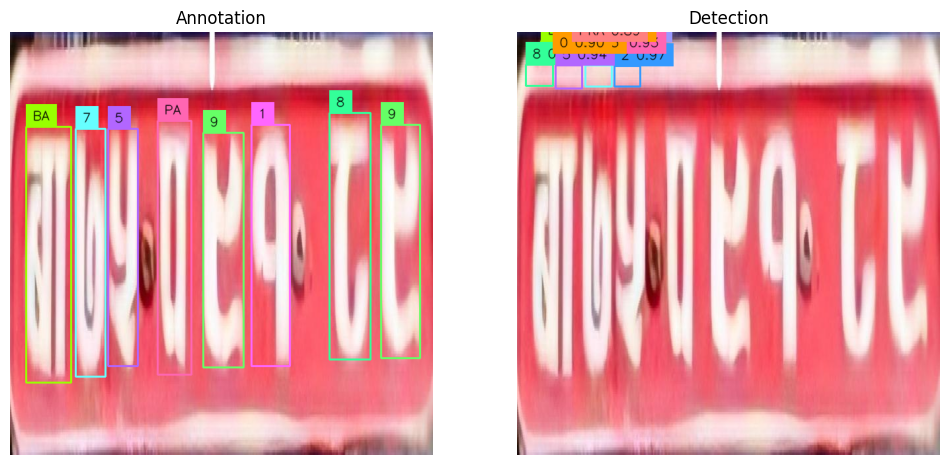

In [77]:
from rfdetr import RFDETRNano
import supervision as sv
from PIL import Image

# path, image, annotations = ds[0]
# image = Image.open(path)

detections = model.predict('/content/cropped_detections/1714911343338_jpg.rf.900a0735f777124bb42e1519a6e5df92_crop_0.png', threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

bbox_annotator = sv.BoxAnnotator(color=color,thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])